In [213]:
import numpy as np
import csv
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import random


In [235]:
from sklearn.model_selection import train_test_split
 #首先，读取.CSV文件成矩阵的形式。
my_matrix = np.loadtxt(open("S4AfterNor.csv",encoding='UTF-8'),delimiter=",",skiprows=0)
#health_data = np.load('health_data_3.npy')
X, y = my_matrix[:,:-1],my_matrix[:,-1]
#print(my_matrix)
#X = my_matrix
health_data = np.load('health_data.npy')
health_label = np.load('health_label.npy')

In [3]:
print(len(X_train_health[:800]))

NameError: name 'X_train_health' is not defined

In [236]:
#X_real=[]
y_real=[]
X_train_sick = np.load('sick_train_Kmeans_2.npy')
X_val_sick = np.load('sick_val_Kmeans_2.npy')
X_train_health = np.load('health_train_Kmeans_2.npy')


X_real = np.vstack((X_train_sick,X_val_sick,X_train_health[:60]))

print(len(X_real))


for n in range(len(X_real)-60):
    
    #X_real.append(X[n])
    y_real.append(1)

for n in range(60):
    y_real.append(0)
    
print(len(X_real))
print(len(y_real))


162
162
162


In [237]:
criterion = nn.BCELoss()

X_real = Variable(torch.from_numpy(np.array(X_real)).float(), requires_grad=True)
#health_data = Variable(torch.from_numpy(health_data[200:]).float(), requires_grad=True)
#X_all = Variable(torch.from_numpy(np.array(X_all)).float(), requires_grad=True)


Y_real = Variable(torch.tensor(y_real)).float()
    
rand_Y = np.random.randint(0,1,(X_real.size()[0],1))
Y_fake = Variable(torch.tensor(rand_Y)).float()
    

In [238]:
print(Y_real.size())
Y_real=Y_real.reshape(Y_real.shape[0], 1)
Y_fake=Y_fake.reshape(Y_fake.shape[0], 1)


torch.Size([162])


In [239]:
torch.manual_seed(0)#for reproducibility

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)
        
def init_weights(net_layer):
    try:
        net_layer.apply(weights_init_normal)
    except:
        raise NotImplementedError('weights initialization error')

def init_weights(net_layer):
    try:
        net_layer.apply(weights_init_normal)
    except:
        raise NotImplementedError('weights initialization error')



In [240]:
class autoencoder(nn.Module):#generator
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(382, 300),
                                     nn.BatchNorm1d(300),
                                     nn.ReLU(True),
                                     nn.Linear(300, 75),
                                     nn.BatchNorm1d(75),
                                     nn.ReLU(True))
        init_weights(self.encoder)
        
        self.decoder = nn.Sequential(nn.Linear(75, 150),
                                     nn.BatchNorm1d(150),
                                     nn.ReLU(True),
                                     nn.Linear(150, 382))
        init_weights(self.decoder)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x
        

In [241]:
class FCNN(nn.Module):#discriminator
    def __init__(self):
        super(FCNN, self).__init__()
        self.layer = nn.Sequential(nn.Linear(382, 200),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(200),
									nn.Linear(200, 200),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(200),
									nn.Linear(200, 200),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(200),
									nn.Linear(200, 100),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(100),
									nn.Linear(100, 100),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(100),
                                    nn.Linear(100, 1))
                                    
        init_weights(self.layer)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


In [242]:
G = autoencoder()
D = FCNN()

g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.005, weight_decay = 1e-4)
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.005, weight_decay = 1e-4)
current_epoch = 0
reconstructionLoss = nn.SmoothL1Loss()
criterion = nn.BCEWithLogitsLoss()
MSELoss = nn.MSELoss()

In [243]:
G_loss = []
G_ACC = []
D_loss = []
D_ACC = []
STEP = []
for step in range(5000):
    for step_g in range(1):
        
    #训练生成器
        #X_fake = Variable(torch.randn(X_real.size()[0], X_real.size()[1]))
        fake_img = G(X_real)
        fake_out = D(fake_img)
        g_loss_1 = reconstructionLoss(fake_img,X_real)
        g_loss_2 = criterion(fake_out,Y_real)
        #g_loss = -(fake_out.mean())
        g_loss = g_loss_1+g_loss_2
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
       
        Results_G = 0 
        for i in D(fake_img).detach().numpy():
            if i > 0.5:
                Results_G += 1
        
        ACC_G = Results_G / (X_real.size()[0])
    
    
    for step_d in range(1):
    
        real_out = D(X_real)  # import real data to D
        #print(real_out)
        #print(Y_real)
        d_loss_real = criterion(real_out, Y_real)# get the real D' loss
        fake_out = D(fake_img.detach())  # import G' fake data to D
        d_loss_fake = criterion(fake_out, Y_fake)# get the fake D's loss

        d_loss = d_loss_real+ d_loss_fake #+ 0.2*gp # 将真假图片的loss加起来
        d_optimizer.zero_grad()  # 归0梯度
        d_loss.backward() # 反向传播
        d_optimizer.step()
        
        #for p in D.parameters():
         #    p.data.clamp_(-0.01, 0.01)
        
        Results_D_real = 0 
        Results = []
        for i in real_out:
            if i > 0.5:
                Results.append(1)
            else:
                Results.append(0)
        
        correct = 0
        
        for i in range(len(Results)):
            if Results[i] == y[i]:
                correct += 1
        
        D_real_accuracy = correct / float(len(y))
        
        
        
        
        
        #print(Results_D_real)
        
        Results_D_fake = 0
        for i in D(fake_img).detach().numpy():
            if i < 0.5:
                Results_D_fake += 1
        #print(Results_D_fake)
        D_fake_accuracy = Results_D_fake/X_real.size()[0]


        ACC_D =  (D_real_accuracy+D_fake_accuracy)/2
        
          
    
    
   
            #if step == 100:   
           
            
    print('step={},d_loss={},g_loss={}, d_loss+g_loss={}'.format(step, d_loss, g_loss,d_loss + g_loss))
    print('step={},d_acc_real={},d_acc_fake={},d_acc={},g_acc={}'.format(step,  D_real_accuracy
                                                                         , D_fake_accuracy
                                                                         ,ACC_D, ACC_G))
    
    #if d_loss > g_loss*2 :
     #   n = 1
    #if g_loss > d_loss*2:
    #    n = 2
        
        
        
    if step % 10 == 0:
        D_loss.append(d_loss.data)
        #D_ACC.append(ACC_D)
        G_loss.append(g_loss.data)
        #G_ACC.append(ACC_G)
        STEP.append(step)
    
    if step%500 == 0:
        FAKE_label_sick= []
        fake_data_sick = []

        for j in range(2):
            fake_data = Variable(torch.randn(X_real.size()[0], X_real.size()[1]))
            fake_data =  G(fake_data).detach().numpy()
        #FAKE_label_sick=[]
            for i in fake_data:
                fake_data_sick.append(i)
                FAKE_label_sick.append(1)
        #print(fake_data_sick)
        
        
        X_sick=[]
        y_sick=[]
        X_health = []
        y_health = []
        for n in range(len(y)):
            if y[n] == 1:
                X_sick.append(X[n])
                y_sick.append(1)
            else:
                X_health.append(X[n])
                y_health.append(0)
        #print(len(X_real))
        #print(y_real)
        np.save('sick_fakedata_6_15'+'{}'.format(step)+'.npy', fake_data_sick)

step=0,d_loss=1.6645991802215576,g_loss=0.8070576786994934, d_loss+g_loss=2.4716567993164062
step=0,d_acc_real=0.061129568106312294,d_acc_fake=0.6851851851851852,d_acc=0.3731573766457488,g_acc=0.48148148148148145
step=1,d_loss=1.6174359321594238,g_loss=0.7460912466049194, d_loss+g_loss=2.363527297973633
step=1,d_acc_real=0.053156146179401995,d_acc_fake=0.5740740740740741,d_acc=0.31361511012673804,g_acc=0.5123456790123457
step=2,d_loss=1.5815393924713135,g_loss=0.73049396276474, d_loss+g_loss=2.3120334148406982
step=2,d_acc_real=0.05448504983388704,d_acc_fake=0.6234567901234568,d_acc=0.3389709199786719,g_acc=0.49382716049382713
step=3,d_loss=1.5417381525039673,g_loss=0.7266951203346252, d_loss+g_loss=2.2684333324432373
step=3,d_acc_real=0.051827242524916946,d_acc_fake=0.6666666666666666,d_acc=0.3592469545957918,g_acc=0.48148148148148145
step=4,d_loss=1.4979565143585205,g_loss=0.735044538974762, d_loss+g_loss=2.2330009937286377
step=4,d_acc_real=0.051827242524916946,d_acc_fake=0.72839506

step=39,d_loss=1.2283709049224854,g_loss=0.7940211892127991, d_loss+g_loss=2.0223920345306396
step=39,d_acc_real=0.05514950166112957,d_acc_fake=0.9753086419753086,d_acc=0.5152290718182191,g_acc=0.030864197530864196
step=40,d_loss=1.2276030778884888,g_loss=0.7932891845703125, d_loss+g_loss=2.0208921432495117
step=40,d_acc_real=0.05514950166112957,d_acc_fake=0.9753086419753086,d_acc=0.5152290718182191,g_acc=0.030864197530864196
step=41,d_loss=1.2267851829528809,g_loss=0.7933423519134521, d_loss+g_loss=2.020127534866333
step=41,d_acc_real=0.05514950166112957,d_acc_fake=0.9814814814814815,d_acc=0.5183154915713055,g_acc=0.037037037037037035
step=42,d_loss=1.2248756885528564,g_loss=0.7940800189971924, d_loss+g_loss=2.018955707550049
step=42,d_acc_real=0.05514950166112957,d_acc_fake=0.9876543209876543,d_acc=0.521401911324392,g_acc=0.030864197530864196
step=43,d_loss=1.2220839262008667,g_loss=0.795407235622406, d_loss+g_loss=2.017491102218628
step=43,d_acc_real=0.05514950166112957,d_acc_fake=0

step=84,d_loss=1.207148790359497,g_loss=0.8004842400550842, d_loss+g_loss=2.0076329708099365
step=84,d_acc_real=0.05514950166112957,d_acc_fake=0.9938271604938271,d_acc=0.5244883310774784,g_acc=0.006172839506172839
step=85,d_loss=1.2092223167419434,g_loss=0.7993283271789551, d_loss+g_loss=2.0085506439208984
step=85,d_acc_real=0.05514950166112957,d_acc_fake=0.9876543209876543,d_acc=0.521401911324392,g_acc=0.012345679012345678
step=86,d_loss=1.209507942199707,g_loss=0.7991222143173218, d_loss+g_loss=2.0086302757263184
step=86,d_acc_real=0.05514950166112957,d_acc_fake=0.9876543209876543,d_acc=0.521401911324392,g_acc=0.012345679012345678
step=87,d_loss=1.209616780281067,g_loss=0.7989698052406311, d_loss+g_loss=2.0085866451263428
step=87,d_acc_real=0.05514950166112957,d_acc_fake=0.9876543209876543,d_acc=0.521401911324392,g_acc=0.012345679012345678
step=88,d_loss=1.2096415758132935,g_loss=0.7988264560699463, d_loss+g_loss=2.0084681510925293
step=88,d_acc_real=0.05514950166112957,d_acc_fake=0.

step=129,d_loss=1.2032792568206787,g_loss=0.7989218235015869, d_loss+g_loss=2.0022010803222656
step=129,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=130,d_loss=1.2030514478683472,g_loss=0.798930287361145, d_loss+g_loss=2.001981735229492
step=130,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=131,d_loss=1.2028368711471558,g_loss=0.7988865971565247, d_loss+g_loss=2.001723527908325
step=131,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=132,d_loss=1.202702522277832,g_loss=0.7987925410270691, d_loss+g_loss=2.001495122909546
step=132,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=133,d_loss=1.2025909423828125,g_loss=0.7986732721328735, d_loss+g_loss=2.0012640953063965
step=133,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=134,d_loss=1.2024657726287842,g_loss=0.7985485792160034, d_loss+g_loss=2.00

step=174,d_loss=1.2021228075027466,g_loss=0.7921470403671265, d_loss+g_loss=1.994269847869873
step=174,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=175,d_loss=1.2020280361175537,g_loss=0.7920612096786499, d_loss+g_loss=1.9940892457962036
step=175,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=176,d_loss=1.2020084857940674,g_loss=0.791900634765625, d_loss+g_loss=1.9939091205596924
step=176,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=177,d_loss=1.2020663022994995,g_loss=0.7916659116744995, d_loss+g_loss=1.993732213973999
step=177,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=178,d_loss=1.2020870447158813,g_loss=0.7914626598358154, d_loss+g_loss=1.9935497045516968
step=178,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=179,d_loss=1.2022442817687988,g_loss=0.7911232709884644, d_loss+g_loss=1.

step=219,d_loss=1.2022244930267334,g_loss=0.7831709384918213, d_loss+g_loss=1.9853954315185547
step=219,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=220,d_loss=1.2020319700241089,g_loss=0.7832219004631042, d_loss+g_loss=1.9852538108825684
step=220,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=221,d_loss=1.2020680904388428,g_loss=0.7830299139022827, d_loss+g_loss=1.9850980043411255
step=221,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=222,d_loss=1.2024773359298706,g_loss=0.7824623584747314, d_loss+g_loss=1.984939694404602
step=222,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=223,d_loss=1.202160358428955,g_loss=0.7825887203216553, d_loss+g_loss=1.9847490787506104
step=223,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=224,d_loss=1.2020056247711182,g_loss=0.7825542092323303, d_loss+g_loss=1

step=266,d_loss=1.2016741037368774,g_loss=0.7730409502983093, d_loss+g_loss=1.974714994430542
step=266,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=267,d_loss=1.2016371488571167,g_loss=0.7728840112686157, d_loss+g_loss=1.9745211601257324
step=267,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=268,d_loss=1.201589822769165,g_loss=0.772718071937561, d_loss+g_loss=1.974307894706726
step=268,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=269,d_loss=1.2015578746795654,g_loss=0.7725264430046082, d_loss+g_loss=1.9740843772888184
step=269,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=270,d_loss=1.2015323638916016,g_loss=0.772322416305542, d_loss+g_loss=1.9738547801971436
step=270,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=271,d_loss=1.2015128135681152,g_loss=0.7721081972122192, d_loss+g_loss=1.97

step=311,d_loss=1.2038217782974243,g_loss=0.7621641159057617, d_loss+g_loss=1.965985894203186
step=311,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=312,d_loss=1.2035858631134033,g_loss=0.7613880634307861, d_loss+g_loss=1.9649739265441895
step=312,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.0
step=313,d_loss=1.205975890159607,g_loss=0.7593616247177124, d_loss+g_loss=1.9653375148773193
step=313,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.006172839506172839
step=314,d_loss=1.2063302993774414,g_loss=0.7586620450019836, d_loss+g_loss=1.9649922847747803
step=314,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.006172839506172839
step=315,d_loss=1.2055602073669434,g_loss=0.7594218850135803, d_loss+g_loss=1.964982032775879
step=315,d_acc_real=0.05514950166112957,d_acc_fake=1.0,d_acc=0.5275747508305648,g_acc=0.006172839506172839
step=316,d_loss=1.204856634

step=357,d_loss=1.206130027770996,g_loss=0.7492068409919739, d_loss+g_loss=1.9553368091583252
step=357,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=358,d_loss=1.2051866054534912,g_loss=0.749528706073761, d_loss+g_loss=1.9547152519226074
step=358,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=359,d_loss=1.204803466796875,g_loss=0.7495753765106201, d_loss+g_loss=1.9543788433074951
step=359,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=360,d_loss=1.2048654556274414,g_loss=0.7495676875114441, d_loss+g_loss=1.9544332027435303
step=360,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=361,d_loss=1.2046452760696411,g_loss=0.7493414878845215, d_loss+g_loss=1.9539867639541626
step=361,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=362,d_loss=1.204310417175293,g_loss=0.7490687370300293, d_loss+g_loss=1.9

step=403,d_loss=1.2014920711517334,g_loss=0.7389603853225708, d_loss+g_loss=1.9404524564743042
step=403,d_acc_real=0.053820598006644516,d_acc_fake=1.0,d_acc=0.5269102990033223,g_acc=0.0
step=404,d_loss=1.2014598846435547,g_loss=0.7387712597846985, d_loss+g_loss=1.9402310848236084
step=404,d_acc_real=0.053820598006644516,d_acc_fake=1.0,d_acc=0.5269102990033223,g_acc=0.0
step=405,d_loss=1.2014394998550415,g_loss=0.7385551333427429, d_loss+g_loss=1.9399945735931396
step=405,d_acc_real=0.053820598006644516,d_acc_fake=1.0,d_acc=0.5269102990033223,g_acc=0.0
step=406,d_loss=1.2014153003692627,g_loss=0.7383403182029724, d_loss+g_loss=1.9397556781768799
step=406,d_acc_real=0.053820598006644516,d_acc_fake=1.0,d_acc=0.5269102990033223,g_acc=0.0
step=407,d_loss=1.2013978958129883,g_loss=0.7381181120872498, d_loss+g_loss=1.9395160675048828
step=407,d_acc_real=0.053820598006644516,d_acc_fake=1.0,d_acc=0.5269102990033223,g_acc=0.0
step=408,d_loss=1.2013750076293945,g_loss=0.737899661064148, d_loss+g_

step=449,d_loss=1.1991045475006104,g_loss=0.7318301200866699, d_loss+g_loss=1.9309346675872803
step=449,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.0
step=450,d_loss=1.1990642547607422,g_loss=0.7316537499427795, d_loss+g_loss=1.930717945098877
step=450,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.0
step=451,d_loss=1.1990512609481812,g_loss=0.7314538359642029, d_loss+g_loss=1.9305050373077393
step=451,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.0
step=452,d_loss=1.1990481615066528,g_loss=0.7312505841255188, d_loss+g_loss=1.9302988052368164
step=452,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.0
step=453,d_loss=1.1990461349487305,g_loss=0.7310468554496765, d_loss+g_loss=1.9300930500030518
step=453,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.0
step=454,d_loss=1.1990516185760498,g_loss=0.7308375835418701, d_loss+g_loss=

step=497,d_loss=1.1965014934539795,g_loss=0.7236603498458862, d_loss+g_loss=1.9201618432998657
step=497,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=498,d_loss=1.1965200901031494,g_loss=0.7235028147697449, d_loss+g_loss=1.920022964477539
step=498,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=499,d_loss=1.196542501449585,g_loss=0.723344087600708, d_loss+g_loss=1.919886589050293
step=499,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=500,d_loss=1.1965582370758057,g_loss=0.7231964468955994, d_loss+g_loss=1.9197547435760498
step=500,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=501,d_loss=1.1965562105178833,g_loss=0.7230744957923889, d_loss+g_loss=1.919630765914917
step=501,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=502,d_loss=1.1964972019195557,g_loss=0.7230176329612732, d_loss+g_loss=1.91

step=544,d_loss=1.1965371370315552,g_loss=0.7192360758781433, d_loss+g_loss=1.9157731533050537
step=544,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=545,d_loss=1.1965396404266357,g_loss=0.7191700339317322, d_loss+g_loss=1.9157097339630127
step=545,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=546,d_loss=1.1965463161468506,g_loss=0.7191022038459778, d_loss+g_loss=1.9156484603881836
step=546,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=547,d_loss=1.196549415588379,g_loss=0.7190308570861816, d_loss+g_loss=1.9155802726745605
step=547,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=548,d_loss=1.1965566873550415,g_loss=0.718948483467102, d_loss+g_loss=1.9155051708221436
step=548,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=549,d_loss=1.1965487003326416,g_loss=0.7188767790794373, d_loss+g_loss=1

step=590,d_loss=1.1965672969818115,g_loss=0.7160037159919739, d_loss+g_loss=1.9125709533691406
step=590,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=591,d_loss=1.1965841054916382,g_loss=0.7159118056297302, d_loss+g_loss=1.9124958515167236
step=591,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=592,d_loss=1.1965974569320679,g_loss=0.7158218622207642, d_loss+g_loss=1.912419319152832
step=592,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=593,d_loss=1.1966263055801392,g_loss=0.7157185673713684, d_loss+g_loss=1.9123449325561523
step=593,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=594,d_loss=1.1965506076812744,g_loss=0.7157201170921326, d_loss+g_loss=1.9122707843780518
step=594,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=595,d_loss=1.1965423822402954,g_loss=0.7156546115875244, d_loss+g_loss=

step=635,d_loss=1.196446180343628,g_loss=0.7131022810935974, d_loss+g_loss=1.9095485210418701
step=635,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=636,d_loss=1.1964521408081055,g_loss=0.7130374312400818, d_loss+g_loss=1.909489631652832
step=636,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=637,d_loss=1.1964515447616577,g_loss=0.7129755020141602, d_loss+g_loss=1.9094270467758179
step=637,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=638,d_loss=1.1964480876922607,g_loss=0.7129139304161072, d_loss+g_loss=1.9093620777130127
step=638,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=639,d_loss=1.196444034576416,g_loss=0.7128527164459229, d_loss+g_loss=1.9092967510223389
step=639,d_acc_real=0.05249169435215947,d_acc_fake=1.0,d_acc=0.5262458471760797,g_acc=0.0
step=640,d_loss=1.1964409351348877,g_loss=0.7127922773361206, d_loss+g_loss=1.

step=683,d_loss=1.2224023342132568,g_loss=0.7169252634048462, d_loss+g_loss=1.939327597618103
step=683,d_acc_real=0.05913621262458472,d_acc_fake=1.0,d_acc=0.5295681063122923,g_acc=0.006172839506172839
step=684,d_loss=1.2415180206298828,g_loss=0.7086185812950134, d_loss+g_loss=1.950136661529541
step=684,d_acc_real=0.061794019933554815,d_acc_fake=1.0,d_acc=0.5308970099667774,g_acc=0.018518518518518517
step=685,d_loss=1.227454423904419,g_loss=0.7088714241981506, d_loss+g_loss=1.9363257884979248
step=685,d_acc_real=0.05647840531561462,d_acc_fake=0.9629629629629629,d_acc=0.5097206841392887,g_acc=0.0
step=686,d_loss=1.2378449440002441,g_loss=0.7055124044418335, d_loss+g_loss=1.9433573484420776
step=686,d_acc_real=0.061129568106312294,d_acc_fake=0.9938271604938271,d_acc=0.5274783643000697,g_acc=0.0
step=687,d_loss=1.2124102115631104,g_loss=0.7115350961685181, d_loss+g_loss=1.9239453077316284
step=687,d_acc_real=0.05448504983388704,d_acc_fake=1.0,d_acc=0.5272425249169436,g_acc=0.0
step=688,d_l

step=728,d_loss=1.175384521484375,g_loss=0.7184900641441345, d_loss+g_loss=1.8938746452331543
step=728,d_acc_real=0.046511627906976744,d_acc_fake=1.0,d_acc=0.5232558139534884,g_acc=0.0
step=729,d_loss=1.1753753423690796,g_loss=0.7182927131652832, d_loss+g_loss=1.8936680555343628
step=729,d_acc_real=0.046511627906976744,d_acc_fake=1.0,d_acc=0.5232558139534884,g_acc=0.0
step=730,d_loss=1.1753708124160767,g_loss=0.7180973291397095, d_loss+g_loss=1.8934681415557861
step=730,d_acc_real=0.046511627906976744,d_acc_fake=1.0,d_acc=0.5232558139534884,g_acc=0.0
step=731,d_loss=1.1753661632537842,g_loss=0.71791011095047, d_loss+g_loss=1.8932762145996094
step=731,d_acc_real=0.046511627906976744,d_acc_fake=1.0,d_acc=0.5232558139534884,g_acc=0.0
step=732,d_loss=1.175358772277832,g_loss=0.7177337408065796, d_loss+g_loss=1.8930925130844116
step=732,d_acc_real=0.046511627906976744,d_acc_fake=1.0,d_acc=0.5232558139534884,g_acc=0.0
step=733,d_loss=1.1753519773483276,g_loss=0.717564046382904, d_loss+g_loss

step=775,d_loss=1.1729919910430908,g_loss=0.7132144570350647, d_loss+g_loss=1.8862063884735107
step=775,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=776,d_loss=1.172991156578064,g_loss=0.7131495475769043, d_loss+g_loss=1.8861407041549683
step=776,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=777,d_loss=1.1729888916015625,g_loss=0.7130863070487976, d_loss+g_loss=1.8860752582550049
step=777,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=778,d_loss=1.1729881763458252,g_loss=0.7130235433578491, d_loss+g_loss=1.8860117197036743
step=778,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=779,d_loss=1.1729884147644043,g_loss=0.712960958480835, d_loss+g_loss=1.8859493732452393
step=779,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=780,d_loss=1.1729886531829834,g_loss=0.7128992080688477, d_loss+g_loss=1

step=823,d_loss=1.173003911972046,g_loss=0.7108396887779236, d_loss+g_loss=1.8838436603546143
step=823,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=824,d_loss=1.173005223274231,g_loss=0.7108015418052673, d_loss+g_loss=1.8838067054748535
step=824,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=825,d_loss=1.1730083227157593,g_loss=0.7107623219490051, d_loss+g_loss=1.8837707042694092
step=825,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=826,d_loss=1.1730118989944458,g_loss=0.7107227444648743, d_loss+g_loss=1.8837347030639648
step=826,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=827,d_loss=1.1730142831802368,g_loss=0.7106838822364807, d_loss+g_loss=1.8836982250213623
step=827,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=828,d_loss=1.1730070114135742,g_loss=0.7106579542160034, d_loss+g_loss=1

step=869,d_loss=1.1730003356933594,g_loss=0.7094111442565918, d_loss+g_loss=1.8824114799499512
step=869,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=870,d_loss=1.172999620437622,g_loss=0.7093856930732727, d_loss+g_loss=1.88238525390625
step=870,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=871,d_loss=1.1729987859725952,g_loss=0.7093610167503357, d_loss+g_loss=1.8823597431182861
step=871,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=872,d_loss=1.1729979515075684,g_loss=0.7093368768692017, d_loss+g_loss=1.88233482837677
step=872,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=873,d_loss=1.1729971170425415,g_loss=0.709313154220581, d_loss+g_loss=1.8823102712631226
step=873,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=874,d_loss=1.1729975938796997,g_loss=0.7092899084091187, d_loss+g_loss=1.882

step=914,d_loss=1.172985553741455,g_loss=0.7084015011787415, d_loss+g_loss=1.8813869953155518
step=914,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=915,d_loss=1.172985553741455,g_loss=0.7083785533905029, d_loss+g_loss=1.881364107131958
step=915,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=916,d_loss=1.1729849576950073,g_loss=0.7083560228347778, d_loss+g_loss=1.8813409805297852
step=916,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=917,d_loss=1.1729854345321655,g_loss=0.7083314657211304, d_loss+g_loss=1.881316900253296
step=917,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=918,d_loss=1.172985315322876,g_loss=0.708307147026062, d_loss+g_loss=1.881292462348938
step=918,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=919,d_loss=1.172985315322876,g_loss=0.708282470703125, d_loss+g_loss=1.881267

step=962,d_loss=1.1730151176452637,g_loss=0.7077293395996094, d_loss+g_loss=1.880744457244873
step=962,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=963,d_loss=1.173009991645813,g_loss=0.7076954245567322, d_loss+g_loss=1.8807053565979004
step=963,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=964,d_loss=1.1730084419250488,g_loss=0.7076605558395386, d_loss+g_loss=1.8806689977645874
step=964,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=965,d_loss=1.1730072498321533,g_loss=0.7076248526573181, d_loss+g_loss=1.8806321620941162
step=965,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=966,d_loss=1.1730060577392578,g_loss=0.7075881958007812, d_loss+g_loss=1.880594253540039
step=966,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=967,d_loss=1.1730053424835205,g_loss=0.7075505256652832, d_loss+g_loss=1.

step=1009,d_loss=1.1730096340179443,g_loss=0.7065222263336182, d_loss+g_loss=1.8795318603515625
step=1009,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1010,d_loss=1.1730103492736816,g_loss=0.7065032124519348, d_loss+g_loss=1.8795135021209717
step=1010,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1011,d_loss=1.173011302947998,g_loss=0.706484854221344, d_loss+g_loss=1.8794960975646973
step=1011,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1012,d_loss=1.1730116605758667,g_loss=0.7064685821533203, d_loss+g_loss=1.879480242729187
step=1012,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1013,d_loss=1.1730115413665771,g_loss=0.7064491510391235, d_loss+g_loss=1.8794606924057007
step=1013,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1014,d_loss=1.1730118989944458,g_loss=0.7064279317855835, d_los

step=1053,d_loss=1.1730692386627197,g_loss=0.7056820392608643, d_loss+g_loss=1.878751277923584
step=1053,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1054,d_loss=1.1730635166168213,g_loss=0.7056617140769958, d_loss+g_loss=1.878725290298462
step=1054,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1055,d_loss=1.1730599403381348,g_loss=0.705644428730011, d_loss+g_loss=1.878704309463501
step=1055,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1056,d_loss=1.173052430152893,g_loss=0.7056325674057007, d_loss+g_loss=1.8786849975585938
step=1056,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1057,d_loss=1.1730464696884155,g_loss=0.705620527267456, d_loss+g_loss=1.8786669969558716
step=1057,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1058,d_loss=1.173046350479126,g_loss=0.7056025266647339, d_loss+g_

step=1099,d_loss=1.1730473041534424,g_loss=0.7051246166229248, d_loss+g_loss=1.8781719207763672
step=1099,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1100,d_loss=1.1730449199676514,g_loss=0.7051007151603699, d_loss+g_loss=1.878145694732666
step=1100,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1101,d_loss=1.1730451583862305,g_loss=0.7050773501396179, d_loss+g_loss=1.8781225681304932
step=1101,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1102,d_loss=1.1730444431304932,g_loss=0.7050561308860779, d_loss+g_loss=1.8781006336212158
step=1102,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1103,d_loss=1.173047661781311,g_loss=0.7050348520278931, d_loss+g_loss=1.878082513809204
step=1103,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1104,d_loss=1.1730533838272095,g_loss=0.7050142288208008, d_los

step=1145,d_loss=1.1730501651763916,g_loss=0.7054420113563538, d_loss+g_loss=1.8784921169281006
step=1145,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1146,d_loss=1.1730480194091797,g_loss=0.7054277658462524, d_loss+g_loss=1.8784757852554321
step=1146,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1147,d_loss=1.1730386018753052,g_loss=0.7054089307785034, d_loss+g_loss=1.8784475326538086
step=1147,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1148,d_loss=1.173035979270935,g_loss=0.7053815722465515, d_loss+g_loss=1.8784174919128418
step=1148,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1149,d_loss=1.173033356666565,g_loss=0.7053505182266235, d_loss+g_loss=1.8783838748931885
step=1149,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1150,d_loss=1.173030138015747,g_loss=0.7053155303001404, d_los

step=1192,d_loss=1.1730163097381592,g_loss=0.7042216658592224, d_loss+g_loss=1.8772380352020264
step=1192,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1193,d_loss=1.1730135679244995,g_loss=0.7041953802108765, d_loss+g_loss=1.877208948135376
step=1193,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1194,d_loss=1.1730120182037354,g_loss=0.7041692137718201, d_loss+g_loss=1.8771812915802002
step=1194,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1195,d_loss=1.1730114221572876,g_loss=0.7041439414024353, d_loss+g_loss=1.8771553039550781
step=1195,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1196,d_loss=1.1730122566223145,g_loss=0.7041202187538147, d_loss+g_loss=1.8771324157714844
step=1196,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1197,d_loss=1.1730144023895264,g_loss=0.704096794128418, d_lo

step=1238,d_loss=1.1730114221572876,g_loss=0.703536868095398, d_loss+g_loss=1.8765482902526855
step=1238,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1239,d_loss=1.173011302947998,g_loss=0.7035248279571533, d_loss+g_loss=1.8765361309051514
step=1239,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1240,d_loss=1.1730120182037354,g_loss=0.7035121321678162, d_loss+g_loss=1.8765242099761963
step=1240,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1241,d_loss=1.1730111837387085,g_loss=0.7034999132156372, d_loss+g_loss=1.8765110969543457
step=1241,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1242,d_loss=1.173011064529419,g_loss=0.7034857869148254, d_loss+g_loss=1.8764967918395996
step=1242,d_acc_real=0.04584717607973422,d_acc_fake=1.0,d_acc=0.5229235880398672,g_acc=0.0
step=1243,d_loss=1.1730109453201294,g_loss=0.7034727334976196, d_los

step=1283,d_loss=1.2886381149291992,g_loss=0.7200922966003418, d_loss+g_loss=2.008730411529541
step=1283,d_acc_real=0.08172757475083056,d_acc_fake=1.0,d_acc=0.5408637873754153,g_acc=0.0
step=1284,d_loss=1.2101712226867676,g_loss=0.7161737680435181, d_loss+g_loss=1.9263449907302856
step=1284,d_acc_real=0.05581395348837209,d_acc_fake=0.9938271604938271,d_acc=0.5248205569910996,g_acc=0.0
step=1285,d_loss=1.242927074432373,g_loss=0.6843705177307129, d_loss+g_loss=1.927297592163086
step=1285,d_acc_real=0.053156146179401995,d_acc_fake=1.0,d_acc=0.526578073089701,g_acc=0.06790123456790123
step=1286,d_loss=1.2018003463745117,g_loss=0.7197389602661133, d_loss+g_loss=1.921539306640625
step=1286,d_acc_real=0.053156146179401995,d_acc_fake=0.9938271604938271,d_acc=0.5234916533366145,g_acc=0.0
step=1287,d_loss=1.2125213146209717,g_loss=0.7242846488952637, d_loss+g_loss=1.9368059635162354
step=1287,d_acc_real=0.053820598006644516,d_acc_fake=0.9938271604938271,d_acc=0.5238238792502359,g_acc=0.0
step=1

step=1329,d_loss=1.1825871467590332,g_loss=0.715949296951294, d_loss+g_loss=1.8985364437103271
step=1329,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1330,d_loss=1.1825791597366333,g_loss=0.7156187891960144, d_loss+g_loss=1.898197889328003
step=1330,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1331,d_loss=1.182570219039917,g_loss=0.7153056859970093, d_loss+g_loss=1.8978759050369263
step=1331,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1332,d_loss=1.182564377784729,g_loss=0.7150075435638428, d_loss+g_loss=1.8975719213485718
step=1332,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1333,d_loss=1.182559609413147,g_loss=0.7147223949432373, d_loss+g_loss=1.8972820043563843
step=1333,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1334,d_loss=1.1825538873672485,g_loss=0.7144508957862854, d_loss+

step=1375,d_loss=1.1824268102645874,g_loss=0.7084617018699646, d_loss+g_loss=1.8908884525299072
step=1375,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1376,d_loss=1.1824283599853516,g_loss=0.7083747982978821, d_loss+g_loss=1.8908030986785889
step=1376,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1377,d_loss=1.1824288368225098,g_loss=0.7082902193069458, d_loss+g_loss=1.8907190561294556
step=1377,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1378,d_loss=1.1824265718460083,g_loss=0.7082088589668274, d_loss+g_loss=1.8906354904174805
step=1378,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1379,d_loss=1.1824289560317993,g_loss=0.7081263065338135, d_loss+g_loss=1.8905552625656128
step=1379,d_acc_real=0.05116279069767442,d_acc_fake=1.0,d_acc=0.5255813953488372,g_acc=0.0
step=1380,d_loss=1.1824300289154053,g_loss=0.7080461382865906, d_

step=1422,d_loss=1.183127522468567,g_loss=0.709950864315033, d_loss+g_loss=1.893078327178955
step=1422,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1423,d_loss=1.1838427782058716,g_loss=0.7098540663719177, d_loss+g_loss=1.8936967849731445
step=1423,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1424,d_loss=1.1816506385803223,g_loss=0.7129053473472595, d_loss+g_loss=1.8945560455322266
step=1424,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1425,d_loss=1.1804918050765991,g_loss=0.7153527736663818, d_loss+g_loss=1.895844578742981
step=1425,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1426,d_loss=1.179027795791626,g_loss=0.7165958881378174, d_loss+g_loss=1.8956236839294434
step=1426,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1427,d_loss=1.17856764793396,g_loss=0.7173185348510742, d_loss+g_

step=1467,d_loss=1.1754082441329956,g_loss=0.7109854817390442, d_loss+g_loss=1.8863937854766846
step=1467,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1468,d_loss=1.175404667854309,g_loss=0.710863471031189, d_loss+g_loss=1.886268138885498
step=1468,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1469,d_loss=1.1754003763198853,g_loss=0.7107471823692322, d_loss+g_loss=1.8861474990844727
step=1469,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1470,d_loss=1.1753950119018555,g_loss=0.710635781288147, d_loss+g_loss=1.8860307931900024
step=1470,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1471,d_loss=1.1753920316696167,g_loss=0.7105279564857483, d_loss+g_loss=1.8859200477600098
step=1471,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1472,d_loss=1.1753897666931152,g_loss=0.7104244232177734, d_loss

step=1511,d_loss=1.1753909587860107,g_loss=0.707930862903595, d_loss+g_loss=1.883321762084961
step=1511,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1512,d_loss=1.1753861904144287,g_loss=0.707892656326294, d_loss+g_loss=1.8832788467407227
step=1512,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1513,d_loss=1.1753816604614258,g_loss=0.7078549265861511, d_loss+g_loss=1.8832366466522217
step=1513,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1514,d_loss=1.175378441810608,g_loss=0.7078158855438232, d_loss+g_loss=1.8831943273544312
step=1514,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1515,d_loss=1.1753764152526855,g_loss=0.7077760100364685, d_loss+g_loss=1.8831524848937988
step=1515,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1516,d_loss=1.175374984741211,g_loss=0.7077353000640869, d_loss+

step=1558,d_loss=1.1753501892089844,g_loss=0.7056909799575806, d_loss+g_loss=1.881041169166565
step=1558,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1559,d_loss=1.1753499507904053,g_loss=0.7056568264961243, d_loss+g_loss=1.8810067176818848
step=1559,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1560,d_loss=1.1753498315811157,g_loss=0.7056233286857605, d_loss+g_loss=1.8809731006622314
step=1560,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1561,d_loss=1.1753497123718262,g_loss=0.7055903673171997, d_loss+g_loss=1.8809400796890259
step=1561,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1562,d_loss=1.1753495931625366,g_loss=0.7055578231811523, d_loss+g_loss=1.880907416343689
step=1562,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1563,d_loss=1.175349473953247,g_loss=0.705525815486908, d_loss

step=1604,d_loss=1.1753544807434082,g_loss=0.7044352293014526, d_loss+g_loss=1.8797897100448608
step=1604,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1605,d_loss=1.1753547191619873,g_loss=0.7044116854667664, d_loss+g_loss=1.8797664642333984
step=1605,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1606,d_loss=1.1753549575805664,g_loss=0.7043883204460144, d_loss+g_loss=1.8797433376312256
step=1606,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1607,d_loss=1.1753554344177246,g_loss=0.7043650150299072, d_loss+g_loss=1.8797204494476318
step=1607,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1608,d_loss=1.1753554344177246,g_loss=0.7043419480323792, d_loss+g_loss=1.879697322845459
step=1608,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1609,d_loss=1.1753556728363037,g_loss=0.7043190598487854, d_l

step=1650,d_loss=1.175366759300232,g_loss=0.7034763097763062, d_loss+g_loss=1.878843069076538
step=1650,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1651,d_loss=1.1753671169281006,g_loss=0.7034583687782288, d_loss+g_loss=1.8788254261016846
step=1651,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1652,d_loss=1.1753677129745483,g_loss=0.7034400701522827, d_loss+g_loss=1.878807783126831
step=1652,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1653,d_loss=1.1753685474395752,g_loss=0.7034206986427307, d_loss+g_loss=1.8787891864776611
step=1653,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1654,d_loss=1.1753710508346558,g_loss=0.7033976316452026, d_loss+g_loss=1.8787686824798584
step=1654,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1655,d_loss=1.1753714084625244,g_loss=0.7033804059028625, d_los

step=1695,d_loss=1.1754002571105957,g_loss=0.7027591466903687, d_loss+g_loss=1.8781594038009644
step=1695,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1696,d_loss=1.1753997802734375,g_loss=0.7027431726455688, d_loss+g_loss=1.8781429529190063
step=1696,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1697,d_loss=1.1753995418548584,g_loss=0.7027268409729004, d_loss+g_loss=1.8781263828277588
step=1697,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1698,d_loss=1.1753993034362793,g_loss=0.7027101516723633, d_loss+g_loss=1.8781094551086426
step=1698,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1699,d_loss=1.1753990650177002,g_loss=0.7026932835578918, d_loss+g_loss=1.8780922889709473
step=1699,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1700,d_loss=1.175398826599121,g_loss=0.7026762366294861, d_l

step=1740,d_loss=1.1754101514816284,g_loss=0.7020846009254456, d_loss+g_loss=1.8774948120117188
step=1740,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1741,d_loss=1.1754101514816284,g_loss=0.7020705938339233, d_loss+g_loss=1.8774807453155518
step=1741,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1742,d_loss=1.1754097938537598,g_loss=0.7020568251609802, d_loss+g_loss=1.8774666786193848
step=1742,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1743,d_loss=1.175410270690918,g_loss=0.702042818069458, d_loss+g_loss=1.877453088760376
step=1743,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1744,d_loss=1.175410270690918,g_loss=0.7020288109779358, d_loss+g_loss=1.877439022064209
step=1744,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=1745,d_loss=1.175410270690918,g_loss=0.702015221118927, d_loss+g_

step=1785,d_loss=1.206129789352417,g_loss=0.6965155005455017, d_loss+g_loss=1.9026453495025635
step=1785,d_acc_real=0.04850498338870432,d_acc_fake=0.7839506172839507,d_acc=0.4162278003363275,g_acc=0.0
step=1786,d_loss=1.435225009918213,g_loss=0.6341493129730225, d_loss+g_loss=2.0693743228912354
step=1786,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.12962962962962962
step=1787,d_loss=1.4030804634094238,g_loss=0.6313494443893433, d_loss+g_loss=2.0344300270080566
step=1787,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.10493827160493827
step=1788,d_loss=1.3626923561096191,g_loss=0.7013855576515198, d_loss+g_loss=2.064077854156494
step=1788,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1789,d_loss=1.3354442119598389,g_loss=0.7060490846633911, d_loss+g_loss=2.0414934158325195
step=1789,d_acc_real=0.09302325581395349,d_acc_fake=0.9135802469135802,d_acc=0.5033017513637669,g_acc=0.0
step=17

step=1830,d_loss=1.168548345565796,g_loss=0.7185458540916443, d_loss+g_loss=1.887094259262085
step=1830,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1831,d_loss=1.1685307025909424,g_loss=0.7181163430213928, d_loss+g_loss=1.8866469860076904
step=1831,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1832,d_loss=1.1685140132904053,g_loss=0.717690646648407, d_loss+g_loss=1.886204719543457
step=1832,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1833,d_loss=1.1684986352920532,g_loss=0.7172691226005554, d_loss+g_loss=1.8857676982879639
step=1833,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1834,d_loss=1.1684850454330444,g_loss=0.7168536186218262, d_loss+g_loss=1.8853386640548706
step=1834,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1835,d_loss=1.168471097946167,g_loss=0.7164478898048401, d_loss+

step=1875,d_loss=1.1685547828674316,g_loss=0.7074083089828491, d_loss+g_loss=1.8759630918502808
step=1875,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1876,d_loss=1.1686995029449463,g_loss=0.7071685194969177, d_loss+g_loss=1.8758680820465088
step=1876,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1877,d_loss=1.1688960790634155,g_loss=0.7068936228752136, d_loss+g_loss=1.8757896423339844
step=1877,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1878,d_loss=1.1690170764923096,g_loss=0.7067028284072876, d_loss+g_loss=1.8757199048995972
step=1878,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1879,d_loss=1.168966293334961,g_loss=0.706676721572876, d_loss+g_loss=1.875643014907837
step=1879,d_acc_real=0.04717607973421927,d_acc_fake=1.0,d_acc=0.5235880398671097,g_acc=0.0
step=1880,d_loss=1.1690311431884766,g_loss=0.7065393328666687, d_los

step=1919,d_loss=1.3866009712219238,g_loss=0.705741822719574, d_loss+g_loss=2.0923428535461426
step=1919,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1920,d_loss=1.386488437652588,g_loss=0.7065857648849487, d_loss+g_loss=2.093074321746826
step=1920,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1921,d_loss=1.386474370956421,g_loss=0.707588791847229, d_loss+g_loss=2.0940632820129395
step=1921,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1922,d_loss=1.386439561843872,g_loss=0.7085821032524109, d_loss+g_loss=2.0950217247009277
step=1922,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1923,d_loss=1.3864071369171143,g_loss=0.7095017433166504, d_loss+g_loss=2.0959088802337646
step=1923,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1924,d_loss=1.3863966464996338,g_loss=0.7103263139724731, d_loss+g

step=1964,d_loss=1.3863143920898438,g_loss=0.7082793712615967, d_loss+g_loss=2.0945937633514404
step=1964,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1965,d_loss=1.3863142728805542,g_loss=0.7081295251846313, d_loss+g_loss=2.0944437980651855
step=1965,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1966,d_loss=1.386314034461975,g_loss=0.7079853415489197, d_loss+g_loss=2.09429931640625
step=1966,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1967,d_loss=1.3863139152526855,g_loss=0.7078462839126587, d_loss+g_loss=2.0941600799560547
step=1967,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1968,d_loss=1.3863139152526855,g_loss=0.7077125310897827, d_loss+g_loss=2.094026565551758
step=1968,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=1969,d_loss=1.3863136768341064,g_loss=0.7075839042663574, d_loss

step=2009,d_loss=1.3863177299499512,g_loss=0.7047514319419861, d_loss+g_loss=2.091069221496582
step=2009,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2010,d_loss=1.3863179683685303,g_loss=0.7047115564346313, d_loss+g_loss=2.091029644012451
step=2010,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2011,d_loss=1.3863179683685303,g_loss=0.7046723961830139, d_loss+g_loss=2.0909903049468994
step=2011,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2012,d_loss=1.3863179683685303,g_loss=0.704633891582489, d_loss+g_loss=2.090951919555664
step=2012,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2013,d_loss=1.3863177299499512,g_loss=0.7045959234237671, d_loss+g_loss=2.090913772583008
step=2013,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2014,d_loss=1.3863177299499512,g_loss=0.7045589685440063, d_loss+

step=2054,d_loss=1.3863146305084229,g_loss=0.703446090221405, d_loss+g_loss=2.0897607803344727
step=2054,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2055,d_loss=1.3863153457641602,g_loss=0.7034254670143127, d_loss+g_loss=2.089740753173828
step=2055,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2056,d_loss=1.3863149881362915,g_loss=0.7034032940864563, d_loss+g_loss=2.0897183418273926
step=2056,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2057,d_loss=1.3863149881362915,g_loss=0.7033821940422058, d_loss+g_loss=2.0896971225738525
step=2057,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2058,d_loss=1.3863136768341064,g_loss=0.7033605575561523, d_loss+g_loss=2.089674234390259
step=2058,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2059,d_loss=1.3863134384155273,g_loss=0.7033395767211914, d_los

step=2099,d_loss=1.3863086700439453,g_loss=0.7026300430297852, d_loss+g_loss=2.0889387130737305
step=2099,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2100,d_loss=1.3863084316253662,g_loss=0.7026141881942749, d_loss+g_loss=2.0889225006103516
step=2100,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2101,d_loss=1.386307954788208,g_loss=0.7025983929634094, d_loss+g_loss=2.0889062881469727
step=2101,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2102,d_loss=1.386307716369629,g_loss=0.7025826573371887, d_loss+g_loss=2.088890314102173
step=2102,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2103,d_loss=1.3863074779510498,g_loss=0.7025669813156128, d_loss+g_loss=2.088874340057373
step=2103,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2104,d_loss=1.3863071203231812,g_loss=0.7025516033172607, d_loss

step=2145,d_loss=1.3862462043762207,g_loss=0.7020357847213745, d_loss+g_loss=2.0882821083068848
step=2145,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2146,d_loss=1.386235237121582,g_loss=0.7020253539085388, d_loss+g_loss=2.0882606506347656
step=2146,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2147,d_loss=1.386224627494812,g_loss=0.702014148235321, d_loss+g_loss=2.0882387161254883
step=2147,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2148,d_loss=1.3862106800079346,g_loss=0.7020034193992615, d_loss+g_loss=2.088214159011841
step=2148,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2149,d_loss=1.3861920833587646,g_loss=0.7019899487495422, d_loss+g_loss=2.088181972503662
step=2149,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=2150,d_loss=1.3861732482910156,g_loss=0.7019713521003723, d_loss+

step=2190,d_loss=1.3818124532699585,g_loss=0.7023628950119019, d_loss+g_loss=2.0841753482818604
step=2190,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2191,d_loss=1.3819491863250732,g_loss=0.7022905349731445, d_loss+g_loss=2.0842397212982178
step=2191,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2192,d_loss=1.3818343877792358,g_loss=0.7023596167564392, d_loss+g_loss=2.0841939449310303
step=2192,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2193,d_loss=1.3817980289459229,g_loss=0.7023574709892273, d_loss+g_loss=2.084155559539795
step=2193,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2194,d_loss=1.3817805051803589,g_loss=0.7023462653160095, d_loss+g_loss=2.0841267108917236
step=2194,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2195,d_loss=1.3817644119262695,g_loss=0.7023405432701111, d_loss+g

step=2236,d_loss=1.3811928033828735,g_loss=0.7035898566246033, d_loss+g_loss=2.084782600402832
step=2236,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2237,d_loss=1.3783283233642578,g_loss=0.7035026550292969, d_loss+g_loss=2.0818309783935547
step=2237,d_acc_real=0.1009966777408638,d_acc_fake=1.0,d_acc=0.5504983388704319,g_acc=0.0
step=2238,d_loss=1.3690907955169678,g_loss=0.7033978700637817, d_loss+g_loss=2.072488784790039
step=2238,d_acc_real=0.09700996677740864,d_acc_fake=1.0,d_acc=0.5485049833887043,g_acc=0.0
step=2239,d_loss=1.3718760013580322,g_loss=0.7033065557479858, d_loss+g_loss=2.0751824378967285
step=2239,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2240,d_loss=1.3723735809326172,g_loss=0.7031210064888, d_loss+g_loss=2.0754945278167725
step=2240,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2241,d_loss=1.3728225231170654,g_loss=0.7027027606964111, d_loss+g_

step=2279,d_loss=1.3722773790359497,g_loss=0.703912079334259, d_loss+g_loss=2.0761895179748535
step=2279,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2280,d_loss=1.3722769021987915,g_loss=0.7038180232048035, d_loss+g_loss=2.07609486579895
step=2280,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2281,d_loss=1.372277021408081,g_loss=0.7037259340286255, d_loss+g_loss=2.076003074645996
step=2281,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2282,d_loss=1.3722774982452393,g_loss=0.703636646270752, d_loss+g_loss=2.075914144515991
step=2282,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2283,d_loss=1.3722782135009766,g_loss=0.7035503387451172, d_loss+g_loss=2.0758285522460938
step=2283,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2284,d_loss=1.3722822666168213,g_loss=0.7034662961959839, d_loss+g_

step=2324,d_loss=1.3722634315490723,g_loss=0.7017828226089478, d_loss+g_loss=2.0740461349487305
step=2324,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2325,d_loss=1.372262954711914,g_loss=0.7017651796340942, d_loss+g_loss=2.0740280151367188
step=2325,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2326,d_loss=1.3722624778747559,g_loss=0.7017475962638855, d_loss+g_loss=2.074010133743286
step=2326,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2327,d_loss=1.372261643409729,g_loss=0.701730489730835, d_loss+g_loss=2.0739922523498535
step=2327,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2328,d_loss=1.3722610473632812,g_loss=0.7017138004302979, d_loss+g_loss=2.073974847793579
step=2328,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=2329,d_loss=1.372260570526123,g_loss=0.701697587966919, d_loss+g_

step=2370,d_loss=1.3740694522857666,g_loss=0.7013194561004639, d_loss+g_loss=2.0753889083862305
step=2370,d_acc_real=0.09833887043189368,d_acc_fake=0.9629629629629629,d_acc=0.5306509166974283,g_acc=0.0
step=2371,d_loss=1.3942862749099731,g_loss=0.6876139044761658, d_loss+g_loss=2.081900119781494
step=2371,d_acc_real=0.09833887043189368,d_acc_fake=0.9629629629629629,d_acc=0.5306509166974283,g_acc=0.037037037037037035
step=2372,d_loss=1.3910951614379883,g_loss=0.688925564289093, d_loss+g_loss=2.0800206661224365
step=2372,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.037037037037037035
step=2373,d_loss=1.4016414880752563,g_loss=0.6876599788665771, d_loss+g_loss=2.089301586151123
step=2373,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.037037037037037035
step=2374,d_loss=1.4019758701324463,g_loss=0.6875145435333252, d_loss+g_loss=2.0894904136657715
step=2374,d_acc_real=0.10232558139534884,d_acc_fake=0.9629629629629629,d_acc=0

step=2412,d_loss=1.3596322536468506,g_loss=0.6843883395195007, d_loss+g_loss=2.044020652770996
step=2412,d_acc_real=0.09169435215946845,d_acc_fake=1.0,d_acc=0.5458471760797342,g_acc=0.018518518518518517
step=2413,d_loss=1.3407702445983887,g_loss=0.6952181458473206, d_loss+g_loss=2.0359883308410645
step=2413,d_acc_real=0.09036544850498339,d_acc_fake=1.0,d_acc=0.5451827242524917,g_acc=0.0
step=2414,d_loss=1.3297309875488281,g_loss=0.6938848495483398, d_loss+g_loss=2.023615837097168
step=2414,d_acc_real=0.0823920265780731,d_acc_fake=1.0,d_acc=0.5411960132890365,g_acc=0.0
step=2415,d_loss=1.3551920652389526,g_loss=0.6697505712509155, d_loss+g_loss=2.024942636489868
step=2415,d_acc_real=0.07906976744186046,d_acc_fake=1.0,d_acc=0.5395348837209303,g_acc=0.06790123456790123
step=2416,d_loss=1.347488522529602,g_loss=0.674235999584198, d_loss+g_loss=2.0217244625091553
step=2416,d_acc_real=0.08039867109634552,d_acc_fake=0.9753086419753086,d_acc=0.527853656535827,g_acc=0.04938271604938271
step=241

step=2456,d_loss=1.2779138088226318,g_loss=0.6978762149810791, d_loss+g_loss=1.975790023803711
step=2456,d_acc_real=0.06445182724252492,d_acc_fake=1.0,d_acc=0.5322259136212625,g_acc=0.0
step=2457,d_loss=1.2795209884643555,g_loss=0.6964411735534668, d_loss+g_loss=1.9759621620178223
step=2457,d_acc_real=0.06312292358803986,d_acc_fake=1.0,d_acc=0.53156146179402,g_acc=0.0
step=2458,d_loss=1.2776525020599365,g_loss=0.696749746799469, d_loss+g_loss=1.9744021892547607
step=2458,d_acc_real=0.06245847176079734,d_acc_fake=1.0,d_acc=0.5312292358803987,g_acc=0.0
step=2459,d_loss=1.275629997253418,g_loss=0.6965915560722351, d_loss+g_loss=1.9722216129302979
step=2459,d_acc_real=0.061129568106312294,d_acc_fake=1.0,d_acc=0.5305647840531561,g_acc=0.0
step=2460,d_loss=1.2714990377426147,g_loss=0.6971439123153687, d_loss+g_loss=1.9686429500579834
step=2460,d_acc_real=0.061129568106312294,d_acc_fake=1.0,d_acc=0.5305647840531561,g_acc=0.0
step=2461,d_loss=1.2776033878326416,g_loss=0.7013612985610962, d_los

step=2500,d_loss=1.2166240215301514,g_loss=0.7241449356079102, d_loss+g_loss=1.9407689571380615
step=2500,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2501,d_loss=1.2168078422546387,g_loss=0.723471462726593, d_loss+g_loss=1.940279245376587
step=2501,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2502,d_loss=1.2161140441894531,g_loss=0.7236064672470093, d_loss+g_loss=1.9397205114364624
step=2502,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2503,d_loss=1.215985894203186,g_loss=0.7232866287231445, d_loss+g_loss=1.9392725229263306
step=2503,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2504,d_loss=1.2158989906311035,g_loss=0.7228171229362488, d_loss+g_loss=1.938716173171997
step=2504,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2505,d_loss=1.2158881425857544,g_loss=0.7223106622695923, d_loss

step=2544,d_loss=1.2151908874511719,g_loss=0.7113444209098816, d_loss+g_loss=1.9265353679656982
step=2544,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2545,d_loss=1.2151895761489868,g_loss=0.7112454771995544, d_loss+g_loss=1.9264349937438965
step=2545,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2546,d_loss=1.2151880264282227,g_loss=0.7111502885818481, d_loss+g_loss=1.9263383150100708
step=2546,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2547,d_loss=1.2151864767074585,g_loss=0.7110581398010254, d_loss+g_loss=1.9262446165084839
step=2547,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2548,d_loss=1.2151851654052734,g_loss=0.7109694480895996, d_loss+g_loss=1.926154613494873
step=2548,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2549,d_loss=1.2151840925216675,g_loss=0.7108836770057678, d_l

step=2588,d_loss=1.2151747941970825,g_loss=0.7087640762329102, d_loss+g_loss=1.9239388704299927
step=2588,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2589,d_loss=1.215174913406372,g_loss=0.7087252736091614, d_loss+g_loss=1.9239001274108887
step=2589,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2590,d_loss=1.2151750326156616,g_loss=0.708686888217926, d_loss+g_loss=1.9238619804382324
step=2590,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2591,d_loss=1.215174913406372,g_loss=0.7086489796638489, d_loss+g_loss=1.9238238334655762
step=2591,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2592,d_loss=1.2151751518249512,g_loss=0.7086113095283508, d_loss+g_loss=1.9237864017486572
step=2592,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2593,d_loss=1.2151751518249512,g_loss=0.7085739970207214, d_los

step=2632,d_loss=1.215172529220581,g_loss=0.7071691751480103, d_loss+g_loss=1.9223417043685913
step=2632,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2633,d_loss=1.215172290802002,g_loss=0.7071312665939331, d_loss+g_loss=1.922303557395935
step=2633,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2634,d_loss=1.2151721715927124,g_loss=0.7070943713188171, d_loss+g_loss=1.9222664833068848
step=2634,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2635,d_loss=1.215172290802002,g_loss=0.707057774066925, d_loss+g_loss=1.9222300052642822
step=2635,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2636,d_loss=1.2151726484298706,g_loss=0.707020103931427, d_loss+g_loss=1.9221928119659424
step=2636,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2637,d_loss=1.2151730060577393,g_loss=0.7069827914237976, d_loss+g

step=2676,d_loss=1.2151706218719482,g_loss=0.706148624420166, d_loss+g_loss=1.9213192462921143
step=2676,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2677,d_loss=1.215172290802002,g_loss=0.7061318159103394, d_loss+g_loss=1.9213041067123413
step=2677,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2678,d_loss=1.2151720523834229,g_loss=0.7061154246330261, d_loss+g_loss=1.9212875366210938
step=2678,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2679,d_loss=1.215172290802002,g_loss=0.706100583076477, d_loss+g_loss=1.921272873878479
step=2679,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2680,d_loss=1.2151720523834229,g_loss=0.706084668636322, d_loss+g_loss=1.9212567806243896
step=2680,d_acc_real=0.05780730897009967,d_acc_fake=1.0,d_acc=0.5289036544850498,g_acc=0.0
step=2681,d_loss=1.2151732444763184,g_loss=0.7060672044754028, d_loss+g

step=2720,d_loss=1.2144917249679565,g_loss=0.7061927318572998, d_loss+g_loss=1.9206844568252563
step=2720,d_acc_real=0.05714285714285714,d_acc_fake=1.0,d_acc=0.5285714285714286,g_acc=0.0
step=2721,d_loss=1.2161376476287842,g_loss=0.705595076084137, d_loss+g_loss=1.9217326641082764
step=2721,d_acc_real=0.05714285714285714,d_acc_fake=1.0,d_acc=0.5285714285714286,g_acc=0.0
step=2722,d_loss=1.2141075134277344,g_loss=0.7057743668556213, d_loss+g_loss=1.919881820678711
step=2722,d_acc_real=0.05714285714285714,d_acc_fake=1.0,d_acc=0.5285714285714286,g_acc=0.0
step=2723,d_loss=1.2142504453659058,g_loss=0.7061203718185425, d_loss+g_loss=1.9203708171844482
step=2723,d_acc_real=0.05714285714285714,d_acc_fake=1.0,d_acc=0.5285714285714286,g_acc=0.0
step=2724,d_loss=1.2138795852661133,g_loss=0.7061066627502441, d_loss+g_loss=1.9199862480163574
step=2724,d_acc_real=0.05714285714285714,d_acc_fake=1.0,d_acc=0.5285714285714286,g_acc=0.0
step=2725,d_loss=1.2136714458465576,g_loss=0.7058837413787842, d_lo

step=2764,d_loss=1.167013168334961,g_loss=0.7071730494499207, d_loss+g_loss=1.8741862773895264
step=2764,d_acc_real=0.04451827242524917,d_acc_fake=1.0,d_acc=0.5222591362126245,g_acc=0.0
step=2765,d_loss=1.1653714179992676,g_loss=0.7085758447647095, d_loss+g_loss=1.873947262763977
step=2765,d_acc_real=0.04451827242524917,d_acc_fake=1.0,d_acc=0.5222591362126245,g_acc=0.0
step=2766,d_loss=1.1585240364074707,g_loss=0.7091581225395203, d_loss+g_loss=1.8676822185516357
step=2766,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2767,d_loss=1.1582956314086914,g_loss=0.7092474102973938, d_loss+g_loss=1.8675429821014404
step=2767,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2768,d_loss=1.15826416015625,g_loss=0.7093926072120667, d_loss+g_loss=1.8676567077636719
step=2768,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2769,d_loss=1.1584177017211914,g_loss=0.7094360589981079, d_l

step=2808,d_loss=1.1566047668457031,g_loss=0.7067928910255432, d_loss+g_loss=1.8633975982666016
step=2808,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2809,d_loss=1.1566035747528076,g_loss=0.7067514657974243, d_loss+g_loss=1.863355040550232
step=2809,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2810,d_loss=1.156602144241333,g_loss=0.706710934638977, d_loss+g_loss=1.86331307888031
step=2810,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2811,d_loss=1.1566004753112793,g_loss=0.7066724300384521, d_loss+g_loss=1.8632729053497314
step=2811,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2812,d_loss=1.1565988063812256,g_loss=0.7066352367401123, d_loss+g_loss=1.863234043121338
step=2812,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2813,d_loss=1.1565971374511719,g_loss=0.7065991759300232, d_l

step=2852,d_loss=1.1565572023391724,g_loss=0.7056441903114319, d_loss+g_loss=1.862201452255249
step=2852,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2853,d_loss=1.15655517578125,g_loss=0.7056258320808411, d_loss+g_loss=1.8621809482574463
step=2853,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2854,d_loss=1.1565550565719604,g_loss=0.7056071162223816, d_loss+g_loss=1.8621621131896973
step=2854,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2855,d_loss=1.1565550565719604,g_loss=0.7055881023406982, d_loss+g_loss=1.8621431589126587
step=2855,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2856,d_loss=1.1565536260604858,g_loss=0.7055702209472656, d_loss+g_loss=1.8621238470077515
step=2856,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2857,d_loss=1.156552791595459,g_loss=0.7055521607398987, d

step=2896,d_loss=1.1565589904785156,g_loss=0.704919159412384, d_loss+g_loss=1.8614780902862549
step=2896,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2897,d_loss=1.1565659046173096,g_loss=0.7049033045768738, d_loss+g_loss=1.8614692687988281
step=2897,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2898,d_loss=1.156563401222229,g_loss=0.7048891186714172, d_loss+g_loss=1.861452579498291
step=2898,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2899,d_loss=1.1565607786178589,g_loss=0.704878032207489, d_loss+g_loss=1.8614387512207031
step=2899,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2900,d_loss=1.1565603017807007,g_loss=0.704867959022522, d_loss+g_loss=1.8614282608032227
step=2900,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2901,d_loss=1.1565563678741455,g_loss=0.704856812953949, d_l

step=2940,d_loss=1.1565284729003906,g_loss=0.7043771743774414, d_loss+g_loss=1.860905647277832
step=2940,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2941,d_loss=1.1565340757369995,g_loss=0.7043642997741699, d_loss+g_loss=1.8608983755111694
step=2941,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2942,d_loss=1.1565284729003906,g_loss=0.7043547630310059, d_loss+g_loss=1.8608832359313965
step=2942,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2943,d_loss=1.156531572341919,g_loss=0.7043437361717224, d_loss+g_loss=1.8608753681182861
step=2943,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2944,d_loss=1.1565266847610474,g_loss=0.7043330073356628, d_loss+g_loss=1.8608596324920654
step=2944,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2945,d_loss=1.1565310955047607,g_loss=0.7043207883834839,

step=2984,d_loss=1.1565299034118652,g_loss=0.7038818001747131, d_loss+g_loss=1.8604116439819336
step=2984,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2985,d_loss=1.1565300226211548,g_loss=0.7038708329200745, d_loss+g_loss=1.860400915145874
step=2985,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2986,d_loss=1.1565289497375488,g_loss=0.7038598656654358, d_loss+g_loss=1.8603887557983398
step=2986,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2987,d_loss=1.1565274000167847,g_loss=0.7038488984107971, d_loss+g_loss=1.8603763580322266
step=2987,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2988,d_loss=1.1565265655517578,g_loss=0.7038378715515137, d_loss+g_loss=1.8603644371032715
step=2988,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=2989,d_loss=1.156526803970337,g_loss=0.7038266062736511,

step=3028,d_loss=1.1566412448883057,g_loss=0.703402042388916, d_loss+g_loss=1.8600432872772217
step=3028,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3029,d_loss=1.1568083763122559,g_loss=0.7032210230827332, d_loss+g_loss=1.8600294589996338
step=3029,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3030,d_loss=1.156726598739624,g_loss=0.7032970190048218, d_loss+g_loss=1.8600236177444458
step=3030,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3031,d_loss=1.1566492319107056,g_loss=0.7033650279045105, d_loss+g_loss=1.8600142002105713
step=3031,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3032,d_loss=1.1566083431243896,g_loss=0.7034002542495728, d_loss+g_loss=1.8600085973739624
step=3032,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3033,d_loss=1.1565971374511719,g_loss=0.7034019827842712,

step=3072,d_loss=1.1565403938293457,g_loss=0.7026551961898804, d_loss+g_loss=1.859195590019226
step=3072,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3073,d_loss=1.1565401554107666,g_loss=0.7026471495628357, d_loss+g_loss=1.859187364578247
step=3073,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3074,d_loss=1.156540036201477,g_loss=0.7026391625404358, d_loss+g_loss=1.8591792583465576
step=3074,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3075,d_loss=1.1565399169921875,g_loss=0.7026312947273254, d_loss+g_loss=1.8591711521148682
step=3075,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3076,d_loss=1.1565394401550293,g_loss=0.7026240229606628, d_loss+g_loss=1.859163522720337
step=3076,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3077,d_loss=1.1565395593643188,g_loss=0.7026163935661316, d

step=3116,d_loss=1.1565804481506348,g_loss=0.7023449540138245, d_loss+g_loss=1.8589253425598145
step=3116,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3117,d_loss=1.1565757989883423,g_loss=0.7023330926895142, d_loss+g_loss=1.8589088916778564
step=3117,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3118,d_loss=1.1565704345703125,g_loss=0.7023265957832336, d_loss+g_loss=1.8588969707489014
step=3118,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3119,d_loss=1.1565580368041992,g_loss=0.702321469783783, d_loss+g_loss=1.858879566192627
step=3119,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3120,d_loss=1.1565674543380737,g_loss=0.7023162841796875, d_loss+g_loss=1.8588837385177612
step=3120,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3121,d_loss=1.1565625667572021,g_loss=0.7023082971572876,

step=3160,d_loss=1.1565619707107544,g_loss=0.7020515203475952, d_loss+g_loss=1.8586134910583496
step=3160,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3161,d_loss=1.156562089920044,g_loss=0.7020449638366699, d_loss+g_loss=1.8586070537567139
step=3161,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3162,d_loss=1.1565639972686768,g_loss=0.7020391225814819, d_loss+g_loss=1.8586031198501587
step=3162,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3163,d_loss=1.1565637588500977,g_loss=0.7020322680473328, d_loss+g_loss=1.8585960865020752
step=3163,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3164,d_loss=1.1565659046173096,g_loss=0.702021598815918, d_loss+g_loss=1.8585875034332275
step=3164,d_acc_real=0.043853820598006646,d_acc_fake=1.0,d_acc=0.5219269102990033,g_acc=0.0
step=3165,d_loss=1.1565650701522827,g_loss=0.7020147442817688,

step=3204,d_loss=1.3863022327423096,g_loss=0.7091216444969177, d_loss+g_loss=2.095423936843872
step=3204,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3205,d_loss=1.386301040649414,g_loss=0.7089913487434387, d_loss+g_loss=2.095292329788208
step=3205,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3206,d_loss=1.386300802230835,g_loss=0.7088661789894104, d_loss+g_loss=2.0951669216156006
step=3206,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3207,d_loss=1.3863000869750977,g_loss=0.7087422609329224, d_loss+g_loss=2.0950422286987305
step=3207,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3208,d_loss=1.3862996101379395,g_loss=0.7086218595504761, d_loss+g_loss=2.094921588897705
step=3208,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3209,d_loss=1.3862993717193604,g_loss=0.7085052132606506, d_loss+

step=3250,d_loss=1.3863000869750977,g_loss=0.7061620950698853, d_loss+g_loss=2.0924620628356934
step=3250,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3251,d_loss=1.3863000869750977,g_loss=0.7061318159103394, d_loss+g_loss=2.0924320220947266
step=3251,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3252,d_loss=1.3863002061843872,g_loss=0.7061018347740173, d_loss+g_loss=2.0924019813537598
step=3252,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3253,d_loss=1.3863002061843872,g_loss=0.7060724496841431, d_loss+g_loss=2.0923726558685303
step=3253,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3254,d_loss=1.3863003253936768,g_loss=0.7060434222221375, d_loss+g_loss=2.092343807220459
step=3254,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3255,d_loss=1.3863003253936768,g_loss=0.7060146331787109, d_l

step=3294,d_loss=1.3863022327423096,g_loss=0.705090343952179, d_loss+g_loss=2.0913925170898438
step=3294,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3295,d_loss=1.3863024711608887,g_loss=0.7050732374191284, d_loss+g_loss=2.0913758277893066
step=3295,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3296,d_loss=1.3863024711608887,g_loss=0.7050535678863525, d_loss+g_loss=2.091356039047241
step=3296,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3297,d_loss=1.3863027095794678,g_loss=0.7050356864929199, d_loss+g_loss=2.0913383960723877
step=3297,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3298,d_loss=1.3863027095794678,g_loss=0.7050167918205261, d_loss+g_loss=2.0913195610046387
step=3298,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3299,d_loss=1.3863029479980469,g_loss=0.7049998044967651, d_lo

step=3338,d_loss=1.3863049745559692,g_loss=0.7043901681900024, d_loss+g_loss=2.0906951427459717
step=3338,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3339,d_loss=1.3863050937652588,g_loss=0.7043762803077698, d_loss+g_loss=2.090681314468384
step=3339,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3340,d_loss=1.3863050937652588,g_loss=0.7043625116348267, d_loss+g_loss=2.090667724609375
step=3340,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3341,d_loss=1.386305332183838,g_loss=0.7043485045433044, d_loss+g_loss=2.090653896331787
step=3341,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3342,d_loss=1.386305332183838,g_loss=0.7043347358703613, d_loss+g_loss=2.090640068054199
step=3342,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3343,d_loss=1.386305332183838,g_loss=0.7043211460113525, d_loss+g_

step=3384,d_loss=1.386307954788208,g_loss=0.7037875056266785, d_loss+g_loss=2.0900955200195312
step=3384,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3385,d_loss=1.3863080739974976,g_loss=0.7037737965583801, d_loss+g_loss=2.0900819301605225
step=3385,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3386,d_loss=1.3863089084625244,g_loss=0.7037613987922668, d_loss+g_loss=2.0900702476501465
step=3386,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3387,d_loss=1.3863083124160767,g_loss=0.7037486433982849, d_loss+g_loss=2.090056896209717
step=3387,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3388,d_loss=1.386308193206787,g_loss=0.7037357687950134, d_loss+g_loss=2.0900440216064453
step=3388,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3389,d_loss=1.386308193206787,g_loss=0.7037233114242554, d_loss

step=3429,d_loss=1.3863165378570557,g_loss=0.7078708410263062, d_loss+g_loss=2.0941872596740723
step=3429,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3430,d_loss=1.3863162994384766,g_loss=0.7077813744544983, d_loss+g_loss=2.09409761428833
step=3430,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3431,d_loss=1.3863160610198975,g_loss=0.7076926231384277, d_loss+g_loss=2.094008684158325
step=3431,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3432,d_loss=1.3863106966018677,g_loss=0.7076013684272766, d_loss+g_loss=2.093912124633789
step=3432,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3433,d_loss=1.3863085508346558,g_loss=0.7075128555297852, d_loss+g_loss=2.0938215255737305
step=3433,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3434,d_loss=1.3863084316253662,g_loss=0.7074284553527832, d_loss

step=3473,d_loss=1.38631010055542,g_loss=0.7058143019676208, d_loss+g_loss=2.0921244621276855
step=3473,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3474,d_loss=1.38631010055542,g_loss=0.7057937979698181, d_loss+g_loss=2.092103958129883
step=3474,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3475,d_loss=1.38631010055542,g_loss=0.705773651599884, d_loss+g_loss=2.092083692550659
step=3475,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3476,d_loss=1.38631010055542,g_loss=0.7057538628578186, d_loss+g_loss=2.0920639038085938
step=3476,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3477,d_loss=1.3863102197647095,g_loss=0.7057344317436218, d_loss+g_loss=2.0920445919036865
step=3477,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3478,d_loss=1.386310338973999,g_loss=0.7057152986526489, d_loss+g_loss=

step=3519,d_loss=1.38631272315979,g_loss=0.705034077167511, d_loss+g_loss=2.0913467407226562
step=3519,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3520,d_loss=1.38631272315979,g_loss=0.7050195336341858, d_loss+g_loss=2.091332197189331
step=3520,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3521,d_loss=1.38631272315979,g_loss=0.7050051689147949, d_loss+g_loss=2.091317892074585
step=3521,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3522,d_loss=1.3863128423690796,g_loss=0.7049909234046936, d_loss+g_loss=2.091303825378418
step=3522,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3523,d_loss=1.3863129615783691,g_loss=0.7049767971038818, d_loss+g_loss=2.091289758682251
step=3523,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3524,d_loss=1.3863129615783691,g_loss=0.7049627304077148, d_loss+g_loss

step=3565,d_loss=1.3863143920898438,g_loss=0.704427182674408, d_loss+g_loss=2.0907416343688965
step=3565,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3566,d_loss=1.3863143920898438,g_loss=0.7044147253036499, d_loss+g_loss=2.090729236602783
step=3566,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3567,d_loss=1.3863143920898438,g_loss=0.7044022083282471, d_loss+g_loss=2.090716600418091
step=3567,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3568,d_loss=1.3863142728805542,g_loss=0.704389750957489, d_loss+g_loss=2.0907039642333984
step=3568,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3569,d_loss=1.3863143920898438,g_loss=0.7043774127960205, d_loss+g_loss=2.0906918048858643
step=3569,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3570,d_loss=1.3863143920898438,g_loss=0.7043650150299072, d_loss

step=3610,d_loss=1.3862943649291992,g_loss=0.7039439082145691, d_loss+g_loss=2.090238332748413
step=3610,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3611,d_loss=1.3862909078598022,g_loss=0.7039341330528259, d_loss+g_loss=2.0902249813079834
step=3611,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3612,d_loss=1.3862864971160889,g_loss=0.7039244174957275, d_loss+g_loss=2.0902109146118164
step=3612,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3613,d_loss=1.3862806558609009,g_loss=0.7039146423339844, d_loss+g_loss=2.0901951789855957
step=3613,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3614,d_loss=1.386272668838501,g_loss=0.7039048671722412, d_loss+g_loss=2.090177536010742
step=3614,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=3615,d_loss=1.386261224746704,g_loss=0.703895092010498, d_loss+

step=3656,d_loss=1.379305124282837,g_loss=0.7036120891571045, d_loss+g_loss=2.0829172134399414
step=3656,d_acc_real=0.10033222591362126,d_acc_fake=1.0,d_acc=0.5501661129568106,g_acc=0.0
step=3657,d_loss=1.379302978515625,g_loss=0.7035964131355286, d_loss+g_loss=2.082899332046509
step=3657,d_acc_real=0.10033222591362126,d_acc_fake=1.0,d_acc=0.5501661129568106,g_acc=0.0
step=3658,d_loss=1.379300832748413,g_loss=0.7035831809043884, d_loss+g_loss=2.0828840732574463
step=3658,d_acc_real=0.10033222591362126,d_acc_fake=1.0,d_acc=0.5501661129568106,g_acc=0.0
step=3659,d_loss=1.3792985677719116,g_loss=0.7035700082778931, d_loss+g_loss=2.0828685760498047
step=3659,d_acc_real=0.10033222591362126,d_acc_fake=1.0,d_acc=0.5501661129568106,g_acc=0.0
step=3660,d_loss=1.3792957067489624,g_loss=0.7035568952560425, d_loss+g_loss=2.082852602005005
step=3660,d_acc_real=0.10033222591362126,d_acc_fake=1.0,d_acc=0.5501661129568106,g_acc=0.0
step=3661,d_loss=1.3792929649353027,g_loss=0.7035439610481262, d_loss+

step=3700,d_loss=1.3658254146575928,g_loss=0.7038469910621643, d_loss+g_loss=2.0696723461151123
step=3700,d_acc_real=0.09634551495016612,d_acc_fake=1.0,d_acc=0.5481727574750831,g_acc=0.0
step=3701,d_loss=1.3675963878631592,g_loss=0.7039802670478821, d_loss+g_loss=2.0715765953063965
step=3701,d_acc_real=0.09634551495016612,d_acc_fake=1.0,d_acc=0.5481727574750831,g_acc=0.0
step=3702,d_loss=1.3658366203308105,g_loss=0.7039651274681091, d_loss+g_loss=2.0698018074035645
step=3702,d_acc_real=0.09634551495016612,d_acc_fake=1.0,d_acc=0.5481727574750831,g_acc=0.0
step=3703,d_loss=1.3653541803359985,g_loss=0.7036730051040649, d_loss+g_loss=2.0690271854400635
step=3703,d_acc_real=0.09634551495016612,d_acc_fake=1.0,d_acc=0.5481727574750831,g_acc=0.0
step=3704,d_loss=1.3653160333633423,g_loss=0.7036291360855103, d_loss+g_loss=2.0689451694488525
step=3704,d_acc_real=0.09634551495016612,d_acc_fake=1.0,d_acc=0.5481727574750831,g_acc=0.0
step=3705,d_loss=1.3654662370681763,g_loss=0.7034382224082947, d_

step=3744,d_loss=1.2336084842681885,g_loss=0.7090712189674377, d_loss+g_loss=1.9426796436309814
step=3744,d_acc_real=0.06312292358803986,d_acc_fake=1.0,d_acc=0.53156146179402,g_acc=0.0
step=3745,d_loss=1.2306747436523438,g_loss=0.7090140581130981, d_loss+g_loss=1.939688801765442
step=3745,d_acc_real=0.06312292358803986,d_acc_fake=1.0,d_acc=0.53156146179402,g_acc=0.0
step=3746,d_loss=1.229395866394043,g_loss=0.70878005027771, d_loss+g_loss=1.938175916671753
step=3746,d_acc_real=0.06245847176079734,d_acc_fake=1.0,d_acc=0.5312292358803987,g_acc=0.0
step=3747,d_loss=1.2276808023452759,g_loss=0.7084908485412598, d_loss+g_loss=1.9361716508865356
step=3747,d_acc_real=0.06245847176079734,d_acc_fake=1.0,d_acc=0.5312292358803987,g_acc=0.0
step=3748,d_loss=1.2261967658996582,g_loss=0.7082664370536804, d_loss+g_loss=1.9344632625579834
step=3748,d_acc_real=0.061129568106312294,d_acc_fake=1.0,d_acc=0.5305647840531561,g_acc=0.0
step=3749,d_loss=1.2250336408615112,g_loss=0.7082589268684387, d_loss+g_l

step=3787,d_loss=1.2184867858886719,g_loss=0.7097426652908325, d_loss+g_loss=1.9282294511795044
step=3787,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3788,d_loss=1.2181675434112549,g_loss=0.7096808552742004, d_loss+g_loss=1.9278483390808105
step=3788,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3789,d_loss=1.2179853916168213,g_loss=0.7095978856086731, d_loss+g_loss=1.9275832176208496
step=3789,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3790,d_loss=1.2178936004638672,g_loss=0.7095006108283997, d_loss+g_loss=1.927394151687622
step=3790,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3791,d_loss=1.2178515195846558,g_loss=0.7093941569328308, d_loss+g_loss=1.9272456169128418
step=3791,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3792,d_loss=1.217829942703247,g_loss=0.7092806100845337,

step=3832,d_loss=1.217543125152588,g_loss=0.7060079574584961, d_loss+g_loss=1.923551082611084
step=3832,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3833,d_loss=1.2175426483154297,g_loss=0.7059773206710815, d_loss+g_loss=1.9235199689865112
step=3833,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3834,d_loss=1.217543125152588,g_loss=0.7059474587440491, d_loss+g_loss=1.9234905242919922
step=3834,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3835,d_loss=1.2175416946411133,g_loss=0.7059186697006226, d_loss+g_loss=1.9234603643417358
step=3835,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3836,d_loss=1.2175410985946655,g_loss=0.705891489982605, d_loss+g_loss=1.9234325885772705
step=3836,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3837,d_loss=1.2175405025482178,g_loss=0.7058654427528381, d

step=3877,d_loss=1.2175343036651611,g_loss=0.7051721215248108, d_loss+g_loss=1.9227063655853271
step=3877,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3878,d_loss=1.2175343036651611,g_loss=0.7051594257354736, d_loss+g_loss=1.9226937294006348
step=3878,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3879,d_loss=1.2175344228744507,g_loss=0.7051466703414917, d_loss+g_loss=1.9226810932159424
step=3879,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3880,d_loss=1.2175344228744507,g_loss=0.7051341533660889, d_loss+g_loss=1.9226685762405396
step=3880,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3881,d_loss=1.2175347805023193,g_loss=0.7051215767860413, d_loss+g_loss=1.9226562976837158
step=3881,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3882,d_loss=1.2175345420837402,g_loss=0.705109119415283

step=3921,d_loss=1.2175376415252686,g_loss=0.7046535611152649, d_loss+g_loss=1.9221911430358887
step=3921,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3922,d_loss=1.2175378799438477,g_loss=0.7046430110931396, d_loss+g_loss=1.9221808910369873
step=3922,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3923,d_loss=1.2175378799438477,g_loss=0.7046325206756592, d_loss+g_loss=1.9221704006195068
step=3923,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3924,d_loss=1.2175381183624268,g_loss=0.7046218514442444, d_loss+g_loss=1.9221599102020264
step=3924,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3925,d_loss=1.2175382375717163,g_loss=0.7046113610267639, d_loss+g_loss=1.922149658203125
step=3925,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3926,d_loss=1.2175383567810059,g_loss=0.704600989818573,

step=3966,d_loss=1.217555284500122,g_loss=0.7041771411895752, d_loss+g_loss=1.9217324256896973
step=3966,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3967,d_loss=1.2175579071044922,g_loss=0.7041643261909485, d_loss+g_loss=1.921722173690796
step=3967,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3968,d_loss=1.2175664901733398,g_loss=0.7041449546813965, d_loss+g_loss=1.9217114448547363
step=3968,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3969,d_loss=1.2175793647766113,g_loss=0.7041209936141968, d_loss+g_loss=1.921700358390808
step=3969,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3970,d_loss=1.217598557472229,g_loss=0.7040908932685852, d_loss+g_loss=1.921689510345459
step=3970,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=3971,d_loss=1.2176244258880615,g_loss=0.7040597200393677, d_

step=4011,d_loss=1.2175688743591309,g_loss=0.7036065459251404, d_loss+g_loss=1.921175479888916
step=4011,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4012,d_loss=1.2175676822662354,g_loss=0.7035918235778809, d_loss+g_loss=1.9211595058441162
step=4012,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4013,d_loss=1.2175666093826294,g_loss=0.703576385974884, d_loss+g_loss=1.9211430549621582
step=4013,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4014,d_loss=1.217565655708313,g_loss=0.703561544418335, d_loss+g_loss=1.921127200126648
step=4014,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4015,d_loss=1.217564344406128,g_loss=0.7035471796989441, d_loss+g_loss=1.9211115837097168
step=4015,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4016,d_loss=1.2175633907318115,g_loss=0.7035331130027771, d_l

step=4055,d_loss=1.2175521850585938,g_loss=0.7030375003814697, d_loss+g_loss=1.9205896854400635
step=4055,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4056,d_loss=1.217552900314331,g_loss=0.7030245661735535, d_loss+g_loss=1.9205775260925293
step=4056,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4057,d_loss=1.217555046081543,g_loss=0.7030097842216492, d_loss+g_loss=1.920564889907837
step=4057,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4058,d_loss=1.217555284500122,g_loss=0.7029973864555359, d_loss+g_loss=1.9205527305603027
step=4058,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4059,d_loss=1.2175559997558594,g_loss=0.7029852271080017, d_loss+g_loss=1.9205412864685059
step=4059,d_acc_real=0.059800664451827246,d_acc_fake=1.0,d_acc=0.5299003322259136,g_acc=0.0
step=4060,d_loss=1.2175571918487549,g_loss=0.7029719948768616, d

step=4099,d_loss=1.3863393068313599,g_loss=0.7077011466026306, d_loss+g_loss=2.0940403938293457
step=4099,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4100,d_loss=1.386322021484375,g_loss=0.7079644203186035, d_loss+g_loss=2.0942864418029785
step=4100,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4101,d_loss=1.3863205909729004,g_loss=0.7081636190414429, d_loss+g_loss=2.094484329223633
step=4101,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4102,d_loss=1.3863165378570557,g_loss=0.708309531211853, d_loss+g_loss=2.094625949859619
step=4102,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4103,d_loss=1.3863186836242676,g_loss=0.7084077000617981, d_loss+g_loss=2.094726324081421
step=4103,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4104,d_loss=1.3863224983215332,g_loss=0.7084640860557556, d_loss+

step=4144,d_loss=1.3722716569900513,g_loss=0.7047497630119324, d_loss+g_loss=2.077021360397339
step=4144,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4145,d_loss=1.3722712993621826,g_loss=0.7047035694122314, d_loss+g_loss=2.076974868774414
step=4145,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4146,d_loss=1.3722712993621826,g_loss=0.7046599388122559, d_loss+g_loss=2.0769312381744385
step=4146,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4147,d_loss=1.372271180152893,g_loss=0.7046173214912415, d_loss+g_loss=2.0768885612487793
step=4147,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4148,d_loss=1.3722724914550781,g_loss=0.7045760750770569, d_loss+g_loss=2.0768485069274902
step=4148,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4149,d_loss=1.3722742795944214,g_loss=0.7045363187789917, d_los

step=4188,d_loss=1.372236967086792,g_loss=0.7036714553833008, d_loss+g_loss=2.0759084224700928
step=4188,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4189,d_loss=1.372234582901001,g_loss=0.7036569714546204, d_loss+g_loss=2.0758914947509766
step=4189,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4190,d_loss=1.3722347021102905,g_loss=0.7036425471305847, d_loss+g_loss=2.0758771896362305
step=4190,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4191,d_loss=1.3722341060638428,g_loss=0.7036283016204834, d_loss+g_loss=2.075862407684326
step=4191,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4192,d_loss=1.3722333908081055,g_loss=0.7036141753196716, d_loss+g_loss=2.075847625732422
step=4192,d_acc_real=0.09833887043189368,d_acc_fake=1.0,d_acc=0.5491694352159469,g_acc=0.0
step=4193,d_loss=1.3722326755523682,g_loss=0.703600287437439, d_loss+

step=4232,d_loss=1.3672089576721191,g_loss=0.6781547665596008, d_loss+g_loss=2.045363664627075
step=4232,d_acc_real=0.0850498338870432,d_acc_fake=0.9876543209876543,d_acc=0.5363520774373487,g_acc=0.06790123456790123
step=4233,d_loss=1.3585695028305054,g_loss=0.6802034378051758, d_loss+g_loss=2.0387730598449707
step=4233,d_acc_real=0.08372093023255814,d_acc_fake=0.9938271604938271,d_acc=0.5387740453631926,g_acc=0.06790123456790123
step=4234,d_loss=1.3570363521575928,g_loss=0.6878905892372131, d_loss+g_loss=2.044926881790161
step=4234,d_acc_real=0.08903654485049833,d_acc_fake=0.9938271604938271,d_acc=0.5414318526721628,g_acc=0.012345679012345678
step=4235,d_loss=1.3380126953125,g_loss=0.7051795721054077, d_loss+g_loss=2.0431923866271973
step=4235,d_acc_real=0.09501661129568106,d_acc_fake=1.0,d_acc=0.5475083056478405,g_acc=0.006172839506172839
step=4236,d_loss=1.3369801044464111,g_loss=0.6930397152900696, d_loss+g_loss=2.030019760131836
step=4236,d_acc_real=0.08039867109634552,d_acc_fake=

step=4275,d_loss=1.1787216663360596,g_loss=0.7150117754936218, d_loss+g_loss=1.8937335014343262
step=4275,d_acc_real=0.04983388704318937,d_acc_fake=1.0,d_acc=0.5249169435215947,g_acc=0.0
step=4276,d_loss=1.1784393787384033,g_loss=0.7149450778961182, d_loss+g_loss=1.8933844566345215
step=4276,d_acc_real=0.04983388704318937,d_acc_fake=1.0,d_acc=0.5249169435215947,g_acc=0.0
step=4277,d_loss=1.1783360242843628,g_loss=0.7146447896957397, d_loss+g_loss=1.8929808139801025
step=4277,d_acc_real=0.04983388704318937,d_acc_fake=1.0,d_acc=0.5249169435215947,g_acc=0.0
step=4278,d_loss=1.1782971620559692,g_loss=0.7143324017524719, d_loss+g_loss=1.892629623413086
step=4278,d_acc_real=0.04983388704318937,d_acc_fake=1.0,d_acc=0.5249169435215947,g_acc=0.0
step=4279,d_loss=1.1782948970794678,g_loss=0.7140260934829712, d_loss+g_loss=1.892320990562439
step=4279,d_acc_real=0.04983388704318937,d_acc_fake=1.0,d_acc=0.5249169435215947,g_acc=0.0
step=4280,d_loss=1.1782883405685425,g_loss=0.71373450756073, d_loss

step=4319,d_loss=1.1769895553588867,g_loss=0.7094272375106812, d_loss+g_loss=1.8864167928695679
step=4319,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=4320,d_loss=1.1765248775482178,g_loss=0.7096335291862488, d_loss+g_loss=1.8861584663391113
step=4320,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=4321,d_loss=1.1763534545898438,g_loss=0.7096473574638367, d_loss+g_loss=1.8860008716583252
step=4321,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=4322,d_loss=1.176331877708435,g_loss=0.7095513939857483, d_loss+g_loss=1.8858833312988281
step=4322,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=4323,d_loss=1.1763811111450195,g_loss=0.7093652486801147, d_loss+g_loss=1.8857463598251343
step=4323,d_acc_real=0.04916943521594684,d_acc_fake=1.0,d_acc=0.5245847176079734,g_acc=0.0
step=4324,d_loss=1.1763912439346313,g_loss=0.7091683149337769, d_l

step=4363,d_loss=1.178830862045288,g_loss=0.7019760608673096, d_loss+g_loss=1.8808069229125977
step=4363,d_acc_real=0.04850498338870432,d_acc_fake=0.9938271604938271,d_acc=0.5211660719412657,g_acc=0.006172839506172839
step=4364,d_loss=1.1792452335357666,g_loss=0.7015315294265747, d_loss+g_loss=1.8807767629623413
step=4364,d_acc_real=0.04850498338870432,d_acc_fake=0.9938271604938271,d_acc=0.5211660719412657,g_acc=0.006172839506172839
step=4365,d_loss=1.2141799926757812,g_loss=0.6725658774375916, d_loss+g_loss=1.8867459297180176
step=4365,d_acc_real=0.04850498338870432,d_acc_fake=0.9938271604938271,d_acc=0.5211660719412657,g_acc=0.012345679012345678
step=4366,d_loss=1.3070650100708008,g_loss=0.704871416091919, d_loss+g_loss=2.0119364261627197
step=4366,d_acc_real=0.08970099667774087,d_acc_fake=1.0,d_acc=0.5448504983388704,g_acc=0.0
step=4367,d_loss=1.187544584274292,g_loss=0.7052924633026123, d_loss+g_loss=1.8928370475769043
step=4367,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0

step=4407,d_loss=1.1730371713638306,g_loss=0.7081998586654663, d_loss+g_loss=1.8812370300292969
step=4407,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4408,d_loss=1.1730377674102783,g_loss=0.7080519199371338, d_loss+g_loss=1.881089687347412
step=4408,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4409,d_loss=1.1730365753173828,g_loss=0.7079076766967773, d_loss+g_loss=1.8809442520141602
step=4409,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4410,d_loss=1.173033356666565,g_loss=0.707767128944397, d_loss+g_loss=1.880800485610962
step=4410,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4411,d_loss=1.1730294227600098,g_loss=0.7076305150985718, d_loss+g_loss=1.8806599378585815
step=4411,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4412,d_loss=1.1730252504348755,g_loss=0.7074973583221436, d_loss

step=4451,d_loss=1.1729590892791748,g_loss=0.7047212719917297, d_loss+g_loss=1.8776803016662598
step=4451,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4452,d_loss=1.1729590892791748,g_loss=0.7046864032745361, d_loss+g_loss=1.877645492553711
step=4452,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4453,d_loss=1.1729590892791748,g_loss=0.7046523690223694, d_loss+g_loss=1.8776113986968994
step=4453,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4454,d_loss=1.1729590892791748,g_loss=0.704619288444519, d_loss+g_loss=1.8775783777236938
step=4454,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4455,d_loss=1.1729590892791748,g_loss=0.7045870423316956, d_loss+g_loss=1.8775460720062256
step=4455,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4456,d_loss=1.1729590892791748,g_loss=0.7045556902885437, d_lo

step=4495,d_loss=1.1729575395584106,g_loss=0.7037547826766968, d_loss+g_loss=1.8767123222351074
step=4495,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4496,d_loss=1.1729578971862793,g_loss=0.7037404775619507, d_loss+g_loss=1.87669837474823
step=4496,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4497,d_loss=1.172958254814148,g_loss=0.7037264108657837, d_loss+g_loss=1.8766846656799316
step=4497,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4498,d_loss=1.1729586124420166,g_loss=0.7037124633789062, d_loss+g_loss=1.8766710758209229
step=4498,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4499,d_loss=1.1729592084884644,g_loss=0.7036987543106079, d_loss+g_loss=1.8766579627990723
step=4499,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4500,d_loss=1.1729601621627808,g_loss=0.7036851048469543, d_los

step=4539,d_loss=1.1730059385299683,g_loss=0.703234851360321, d_loss+g_loss=1.8762407302856445
step=4539,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4540,d_loss=1.1730077266693115,g_loss=0.7032207250595093, d_loss+g_loss=1.8762284517288208
step=4540,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4541,d_loss=1.1730892658233643,g_loss=0.7031263709068298, d_loss+g_loss=1.8762156963348389
step=4541,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4542,d_loss=1.1731112003326416,g_loss=0.7030924558639526, d_loss+g_loss=1.8762036561965942
step=4542,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4543,d_loss=1.173127293586731,g_loss=0.7030673027038574, d_loss+g_loss=1.8761945962905884
step=4543,d_acc_real=0.04850498338870432,d_acc_fake=1.0,d_acc=0.5242524916943522,g_acc=0.0
step=4544,d_loss=1.1731464862823486,g_loss=0.7030417323112488, d_lo

step=4583,d_loss=1.3863308429718018,g_loss=0.7081930637359619, d_loss+g_loss=2.0945239067077637
step=4583,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4584,d_loss=1.3863294124603271,g_loss=0.7080185413360596, d_loss+g_loss=2.0943479537963867
step=4584,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4585,d_loss=1.3863284587860107,g_loss=0.7078502774238586, d_loss+g_loss=2.0941786766052246
step=4585,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4586,d_loss=1.3863272666931152,g_loss=0.707687497138977, d_loss+g_loss=2.0940146446228027
step=4586,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4587,d_loss=1.386325478553772,g_loss=0.7075302004814148, d_loss+g_loss=2.093855619430542
step=4587,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4588,d_loss=1.386324167251587,g_loss=0.7073794603347778, d_loss

step=4628,d_loss=1.3863111734390259,g_loss=0.7046898007392883, d_loss+g_loss=2.091001033782959
step=4628,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4629,d_loss=1.386311650276184,g_loss=0.7046608924865723, d_loss+g_loss=2.090972423553467
step=4629,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4630,d_loss=1.3863118886947632,g_loss=0.7046324610710144, d_loss+g_loss=2.090944290161133
step=4630,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4631,d_loss=1.3863122463226318,g_loss=0.70460444688797, d_loss+g_loss=2.090916633605957
step=4631,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4632,d_loss=1.386312484741211,g_loss=0.7045778036117554, d_loss+g_loss=2.090890407562256
step=4632,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4633,d_loss=1.38631272315979,g_loss=0.7045512795448303, d_loss+g_loss

step=4673,d_loss=1.38631272315979,g_loss=0.7039129734039307, d_loss+g_loss=2.0902256965637207
step=4673,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4674,d_loss=1.38631272315979,g_loss=0.7039028406143188, d_loss+g_loss=2.0902156829833984
step=4674,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4675,d_loss=1.38631272315979,g_loss=0.7038929462432861, d_loss+g_loss=2.090205669403076
step=4675,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4676,d_loss=1.38631272315979,g_loss=0.7038831114768982, d_loss+g_loss=2.090195894241333
step=4676,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4677,d_loss=1.38631272315979,g_loss=0.7038732767105103, d_loss+g_loss=2.09018611907959
step=4677,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4678,d_loss=1.38631272315979,g_loss=0.7038637399673462, d_loss+g_loss=2.09

step=4718,d_loss=1.3863122463226318,g_loss=0.7035584449768066, d_loss+g_loss=2.0898706912994385
step=4718,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4719,d_loss=1.3863122463226318,g_loss=0.7035521268844604, d_loss+g_loss=2.0898642539978027
step=4719,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4720,d_loss=1.3863122463226318,g_loss=0.7035458087921143, d_loss+g_loss=2.089858055114746
step=4720,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4721,d_loss=1.3863122463226318,g_loss=0.7035395503044128, d_loss+g_loss=2.0898518562316895
step=4721,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4722,d_loss=1.3863122463226318,g_loss=0.7035332322120667, d_loss+g_loss=2.0898454189300537
step=4722,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4723,d_loss=1.3863122463226318,g_loss=0.7035270929336548, d_l

step=4763,d_loss=1.386312484741211,g_loss=0.7032955288887024, d_loss+g_loss=2.0896079540252686
step=4763,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4764,d_loss=1.3863123655319214,g_loss=0.7032901048660278, d_loss+g_loss=2.089602470397949
step=4764,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4765,d_loss=1.3863129615783691,g_loss=0.7032843828201294, d_loss+g_loss=2.089597225189209
step=4765,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4766,d_loss=1.38631272315979,g_loss=0.7032793164253235, d_loss+g_loss=2.0895919799804688
step=4766,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4767,d_loss=1.38631272315979,g_loss=0.7032738327980042, d_loss+g_loss=2.0895864963531494
step=4767,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4768,d_loss=1.38631272315979,g_loss=0.7032684087753296, d_loss+g_lo

step=4808,d_loss=1.3863121271133423,g_loss=0.7030789256095886, d_loss+g_loss=2.089390993118286
step=4808,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4809,d_loss=1.3863120079040527,g_loss=0.7030744552612305, d_loss+g_loss=2.089386463165283
step=4809,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4810,d_loss=1.3863118886947632,g_loss=0.7030699253082275, d_loss+g_loss=2.089381694793701
step=4810,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4811,d_loss=1.3863118886947632,g_loss=0.7030652165412903, d_loss+g_loss=2.0893771648406982
step=4811,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4812,d_loss=1.3863117694854736,g_loss=0.7030606865882874, d_loss+g_loss=2.089372396469116
step=4812,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4813,d_loss=1.3863117694854736,g_loss=0.7030560970306396, d_loss

step=4852,d_loss=1.3863155841827393,g_loss=0.7028959393501282, d_loss+g_loss=2.0892114639282227
step=4852,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4853,d_loss=1.3863158226013184,g_loss=0.7028918266296387, d_loss+g_loss=2.089207649230957
step=4853,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4854,d_loss=1.3863157033920288,g_loss=0.702888011932373, d_loss+g_loss=2.0892038345336914
step=4854,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4855,d_loss=1.3863155841827393,g_loss=0.7028841972351074, d_loss+g_loss=2.0891997814178467
step=4855,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4856,d_loss=1.3863154649734497,g_loss=0.7028802037239075, d_loss+g_loss=2.089195728302002
step=4856,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4857,d_loss=1.3863154649734497,g_loss=0.7028762102127075, d_los

step=4896,d_loss=1.3863131999969482,g_loss=0.7027290463447571, d_loss+g_loss=2.0890421867370605
step=4896,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4897,d_loss=1.3863133192062378,g_loss=0.7027254700660706, d_loss+g_loss=2.089038848876953
step=4897,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4898,d_loss=1.3863130807876587,g_loss=0.7027216553688049, d_loss+g_loss=2.0890347957611084
step=4898,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4899,d_loss=1.3863129615783691,g_loss=0.7027179598808289, d_loss+g_loss=2.0890309810638428
step=4899,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4900,d_loss=1.3863129615783691,g_loss=0.7027143836021423, d_loss+g_loss=2.0890274047851562
step=4900,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4901,d_loss=1.3863131999969482,g_loss=0.7027106881141663, d_l

step=4941,d_loss=1.3863112926483154,g_loss=0.7025609612464905, d_loss+g_loss=2.088872194290161
step=4941,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4942,d_loss=1.3863112926483154,g_loss=0.7025573253631592, d_loss+g_loss=2.0888686180114746
step=4942,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4943,d_loss=1.3863111734390259,g_loss=0.7025537490844727, d_loss+g_loss=2.088864803314209
step=4943,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4944,d_loss=1.3863110542297363,g_loss=0.7025501728057861, d_loss+g_loss=2.0888612270355225
step=4944,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4945,d_loss=1.3863109350204468,g_loss=0.7025465965270996, d_loss+g_loss=2.088857650756836
step=4945,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4946,d_loss=1.3863110542297363,g_loss=0.7025430202484131, d_los

step=4986,d_loss=1.3863033056259155,g_loss=0.7024033069610596, d_loss+g_loss=2.0887064933776855
step=4986,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4987,d_loss=1.386303186416626,g_loss=0.702399492263794, d_loss+g_loss=2.08870267868042
step=4987,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4988,d_loss=1.3863027095794678,g_loss=0.7023956179618835, d_loss+g_loss=2.088698387145996
step=4988,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4989,d_loss=1.3863024711608887,g_loss=0.7023923397064209, d_loss+g_loss=2.0886948108673096
step=4989,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4990,d_loss=1.3863019943237305,g_loss=0.7023887634277344, d_loss+g_loss=2.088690757751465
step=4990,d_acc_real=0.10232558139534884,d_acc_fake=1.0,d_acc=0.5511627906976744,g_acc=0.0
step=4991,d_loss=1.3863013982772827,g_loss=0.7023851275444031, d_loss+g

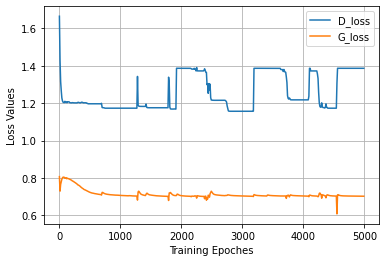

In [245]:
plt.plot(STEP,D_loss)
#plt.legend(labels=["D_loss"])
plt.plot(STEP,G_loss)
plt.legend(labels=["D_loss","G_loss"])
plt.xlabel('Training Epoches')
plt.ylabel('Loss Values')
plt.grid()
plt.savefig('Loss_GAN_5.tif', dpi = 400)
plt.show()

In [264]:
FAKE_label_sick= []
FAKE_label_health= []

fake_data_sick_1 = []
fake_data_sick_2 = []
fake_data_sick_3 = []
fake_data_sick_4 = []
fake_data_sick_5 = []
fake_data_health = []


In [270]:

for j in range(8):
    fake_data = Variable(torch.randn(X_real.size()[0], X_real.size()[1]))
    fake_data =  G(fake_data).detach().numpy()
#FAKE_label_sick=[]
    for i in fake_data[:-20]:
        #print(len(fake_data_sick_5))
        fake_data_sick_1.append(i)
        #print(len(fake_data_sick_5))
        FAKE_label_sick.append(1)
#print(fake_data_sick)


X_sick=[]
y_sick=[]
X_health = []
y_health = []
for n in range(len(y)):
    if y[n] == 1:
        X_sick.append(X[n])
        y_sick.append(1)
    else:
        X_health.append(X[n])
        y_health.append(0)
#print(len(X_real))
#print(y_real)



142
[0.423432   0.39169788 0.5607913  0.18372732 0.6604362  0.5702069
 0.75911254 0.14692429 0.44808957 0.47952244 0.9035353  0.20576844
 0.8667114  0.481591   0.3824568  0.4714022  0.18779412 0.15875234
 0.1303428  0.55464536 0.4833734  0.4563246  0.33270714 0.50951946
 0.4210818  0.4957812  0.49618295 0.27083722 0.529634   0.52321005
 0.445827   0.5704062  0.53017354 0.33267617 0.45572075 0.44102353
 0.46077955 0.3075273  0.38660523 0.4416072  0.39152622 0.43105128
 0.34174308 0.4531975  0.29280943 0.305103   0.3111228  0.3158199
 0.385362   0.30207226 0.3796423  0.4446297  0.36885557 0.35348427
 0.43694013 0.40242234 0.44462758 0.47897816 0.409032   0.47270492
 0.32220635 0.5209668  0.36058855 0.51278615 0.34585148 0.38602665
 0.44897655 0.54278225 0.5538541  0.3302076  0.44366366 0.5817281
 0.46601084 0.38410646 0.4922923  0.4304819  0.49705887 0.4672196
 0.4234376  0.4998241  0.48743647 0.4294481  0.47578937 0.5148393
 0.45814362 0.47987932 0.27786377 0.44944727 0.34569007 0.52873

 0.45786777 0.46093193 0.5173788  0.3707446 ]
[0.56169486 0.4661271  0.6495857  0.26608983 0.3633689  0.7318221
 0.6934404  0.13627966 0.5724406  0.40979305 0.88601965 0.3139913
 0.7602067  0.50675917 0.27041298 0.48170736 0.24345732 0.21882394
 0.16008429 0.44566652 0.60144246 0.45899856 0.53205854 0.59542817
 0.61318827 0.509351   0.59477204 0.49525458 0.42379385 0.45703685
 0.6212158  0.5766864  0.5462221  0.6358956  0.60743684 0.57214594
 0.53898096 0.6261791  0.5797028  0.3698736  0.6239261  0.53549796
 0.5225324  0.6355658  0.6227312  0.4750484  0.59752417 0.5988027
 0.66608626 0.55896413 0.45974296 0.48624125 0.54616123 0.38415447
 0.526001   0.52103984 0.5550999  0.51902217 0.52983624 0.6075591
 0.37790015 0.5285643  0.4928531  0.46087    0.5038294  0.5738475
 0.69252914 0.6113502  0.6451515  0.4978637  0.5224851  0.43810004
 0.5041167  0.632511   0.4849654  0.39973718 0.44787636 0.5046727
 0.4460321  0.5209792  0.47074997 0.69380563 0.45729527 0.6007464
 0.59062445 0.59669816 

 0.42155316 0.40906924 0.49882746 0.41050708]
[0.4297661  0.37215906 0.5344739  0.30807453 0.6587173  0.54465246
 0.69679177 0.19307026 0.4208004  0.4464099  0.85701716 0.316301
 0.79507625 0.47360995 0.39193568 0.46765342 0.24626912 0.22378501
 0.17429361 0.5317553  0.51718974 0.4913728  0.39571115 0.5051812
 0.44736457 0.48602587 0.49773088 0.33756194 0.50632566 0.501279
 0.44647843 0.57737434 0.5114649  0.41951734 0.45190775 0.45138517
 0.44982025 0.38938123 0.43265957 0.45083192 0.4418011  0.45117334
 0.41190732 0.47559628 0.37408555 0.38146377 0.37201765 0.38921773
 0.4288644  0.38645235 0.41050473 0.4654937  0.4012831  0.4170377
 0.46476436 0.4275099  0.49893355 0.52216065 0.4391961  0.4561183
 0.36046696 0.52056456 0.41975194 0.4879675  0.40657175 0.41070476
 0.46640146 0.54251945 0.5242215  0.38980454 0.4525906  0.5378515
 0.4652346  0.4177597  0.5028969  0.45801115 0.4760461  0.47887918
 0.44711062 0.481177   0.4881194  0.45731184 0.47934553 0.51901937
 0.47797748 0.5013872  0

 0.43058628 0.4178048  0.52181697 0.3630249 ]
[0.46181077 0.4065359  0.55457854 0.4561845  0.62995255 0.57480365
 0.66064775 0.20982672 0.44526574 0.44196793 0.83298427 0.3978912
 0.7102621  0.50145894 0.37957972 0.4841622  0.29679576 0.27902704
 0.2074201  0.51445395 0.53625643 0.4881555  0.44276744 0.5441119
 0.5054667  0.50175697 0.5117951  0.38354897 0.5219301  0.5279631
 0.4999919  0.5824376  0.50165725 0.45793664 0.51121724 0.48223537
 0.48186177 0.4363694  0.48598188 0.43647373 0.49878323 0.47965792
 0.43843502 0.50308454 0.4201008  0.40354565 0.41656345 0.42310098
 0.4756103  0.42145345 0.43294325 0.4877939  0.42929402 0.44605052
 0.48653993 0.46620575 0.51625985 0.5398204  0.4893266  0.4865808
 0.39412558 0.5176912  0.447322   0.48757893 0.4292812  0.46511692
 0.52216405 0.5373925  0.55127126 0.43060192 0.49121585 0.52747065
 0.48805436 0.4905092  0.5085893  0.44119564 0.4958179  0.50142705
 0.46519405 0.47927958 0.49968597 0.5212355  0.4825656  0.52862954
 0.51159143 0.545089

In [271]:
for j in range(8):
    fake_data = Variable(torch.randn(X_real.size()[0], X_real.size()[1]))
    fake_data =  G(fake_data).detach().numpy()
#FAKE_label_sick=[]
    for i in fake_data[-20:]:
        fake_data_health.append(i)
        FAKE_label_health.append(1)
#print(fake_data_sick)


X_sick=[]
y_sick=[]
X_health = []
y_health = []
for n in range(len(y)):
    if y[n] == 1:
        X_sick.append(X[n])
        y_sick.append(1)
    else:
        X_health.append(X[n])
        y_health.append(0)
#print(len(X_real))
#print(y_real)

In [272]:
fake_data_sick = np.vstack((fake_data_sick_1,fake_data_sick_2,fake_data_sick_3,fake_data_sick_4,fake_data_sick_5))
print(fake_data_sick)
fake_data_sick = fake_data_sick.astype('float32')
#fake_data_health = fake_data_health.astype('float32')
print(len(fake_data_sick))

[[0.5642613  0.4443003  0.6172665  ... 0.61356306 0.5114775  0.33388612]
 [0.30808085 0.26763657 0.4483222  ... 0.50001407 0.5006736  0.3480487 ]
 [0.5262681  0.42819634 0.6048388  ... 0.5330868  0.50939506 0.38871258]
 ...
 [0.551432   0.39202738 0.55483216 ... 0.7054515  0.43231544 0.3793368 ]
 [0.31835872 0.27618703 0.44315365 ... 0.5158666  0.49267292 0.33353913]
 [0.5012447  0.46738213 0.6454527  ... 0.35351488 0.5062346  0.40386653]]
6816


In [273]:
#np.save('sick_data.npy',X_sick)
#np.save('sick_label.npy',y_sick)
#np.save('health_data.npy',X_health)
#np.save('health_label.npy',y_health)
np.save('sick_fakedata_35.npy',fake_data_sick)
np.save('sick_fakelabel.npy',FAKE_label_sick)
np.save('sick_fakel_health.npy',fake_data_health)
np.save('sick_fakelabel_health.npy',FAKE_label_health)



In [210]:
torch.save(G,'G62.pkl')
torch.save(D,'D62.pkl')

In [150]:
D = torch.load('D62.pkl')

In [151]:
health_data = np.load('health_data.npy')
health_label = np.load('health_label.npy')
sick_data = np.load('sick_data.npy')
sick_label = np.load('sick_label.npy')

In [152]:
X_health = Variable(torch.from_numpy(np.array(health_data)).float(), requires_grad=True)
Y_health = Variable(torch.tensor(health_label)).float()
X_sick = Variable(torch.from_numpy(np.array(sick_data)).float(), requires_grad=True)
Y_sick = Variable(torch.tensor(sick_label)).float()

In [153]:
#D(X_health)
number = 0
for i in D(X_health).detach().numpy():
    if i < 0.5:
        number += 1
ACC_D = number / len(X_health)

number = 0
for i in D(X_sick).detach().numpy():
    if i > 0.5:
        number += 1
ACC_G = number / len(X_sick)

In [154]:
print(ACC_D,ACC_G)

1.0 0.5975609756097561
